This EDA nb is using occurrence tables e-mailed from Tiago on 9/27 (duplicated, with rotated lat and long columns)

## Imports + Loading In Data

In [2]:
import pandas as pd


In [3]:
# %pip install openpyxl

In [4]:
# Loading in data w/ rotated coordinates
rep = pd.read_excel('reptilia_occ_genus.xlsm', engine='openpyxl')
syn = pd.read_excel('synapsida_occ_genus.xlsm', engine='openpyxl')
tem = pd.read_excel('temnospondyli_occ_genus.xlsm', engine='openpyxl')

In [5]:
rep['county'].isna().sum()

1495

In [6]:
rep['county'].value_counts()

Apache                    234
Comanche                  152
Rio Arriba                 88
Franklin                   78
Gloucestershire            67
                         ... 
Malmyzh                     1
Anson                       1
Sa√É¬¥ne-et-Loire           1
Huesca                      1
Aliwal North Commonage      1
Name: county, Length: 355, dtype: int64

## Saving Nulls as CSV's

In [7]:
# Seeing how many nulls are in each column will help us decide which columns to drop
nulls_rep = rep.isna().sum()
nulls_syn = syn.isna().sum()
nulls_tem = tem.isna().sum()

# Concatenating the nulls into a single dataframe based on a shared index
# This will allow us to compare the nulls across the three datasets
nulls = pd.concat([nulls_rep, nulls_syn, nulls_tem], axis=1)
nulls.columns = ['Reptilia', 'Synapsida', 'Temnospondyli']

nulls.to_csv('nulls.csv')

In [8]:
# len of nulls df is diff from len of columns in rep
# which means there are columns that are not shared
len(nulls.index), len(rep.columns)

(119, 94)

In [9]:
# Finding which columns rep, syn, and tem do not share
# Crude code, just to see if there are any differences, not finding all differences
# Because any not-shared columns wouldn't be included in the analysis anyway

if rep.columns.all() == syn.columns.all() == tem.columns.all():
    print('All columns are the same')
else:
    diff = rep.columns.difference(syn.columns).difference(tem.columns)
    print(diff)

Index(['abund_in_sediment', 'artifacts', 'component_comments', 'concentration',
       'fossilsfrom1', 'fossilsfrom2', 'lagerstatten', 'lithadj2', 'localbed',
       'localsection', 'minor_lithology2', 'orientation', 'reference_no.x',
       'temporal_resolution'],
      dtype='object')


## Confirming that these are Datasets w/ duplicated rows (eda_duplicates)

In [10]:
# Loading in datasets that I had previously duplicated (i.e., the output of eda_duplicates.ipynb)
rep_old = pd.read_csv('occurrence_tables_1/reptilia_dup.csv')
syn_old = pd.read_csv('occurrence_tables_1/synapsida_dup.csv')
tem_old = pd.read_csv('occurrence_tables_1/temnospondyli_dup.csv')

In [11]:
# Checking that the lengths of the original and new datasets are the same
len(rep_old), len(rep), len(syn_old), len(syn), len(tem_old), len(tem)

(4411, 4411, 3422, 3422, 2247, 2247)

In [12]:
# One last double-check to make sure that the datasets are the same
# All 'abund_values' for "individuals" should be 1
individuals = rep[rep['abund_unit'] == 'individuals']
individuals['abund_value'].value_counts()

1.0    2032
Name: abund_value, dtype: int64

## Filtering to BDNN columns

In [13]:
rep.columns

Index(['id', 'Rotated Lat', 'Rotated Lon', 'occurrence_no', 'pres_mode',
       'preservation_quality', 'common_body_parts', 'abund_value',
       'abund_unit', 'class', 'family', 'genus', 'taxon_environment',
       'life_habit', 'diet', 'early_interval', 'late_interval', 'time_bins',
       'museum', 'collection_no', 'age_max', 'age_min', 'age_median',
       'age_uncer_range', 'lng', 'lat', 'environment', 'occurrence_comments',
       'cc', 'state', 'county', 'formation', 'stratgroup', 'member', 'zone',
       'accepted_rank', 'ref_author', 'ref_pubyr', 'reference_no.x',
       'collection_name', 'collection_subset', 'collection_aka',
       'latlng_basis', 'latlng_precision', 'geogscale', 'geogcomments',
       'paleomodel', 'geoplate', 'paleoage', 'paleolng', 'paleolat',
       'paleomodel2', 'geoplate2', 'paleoage2', 'paleolng2', 'paleolat2',
       'paleomodel3', 'geoplate3', 'paleoage3', 'paleolng3', 'paleolat3',
       'protected', 'stratscale', 'localsection', 'localbed', 'st

In [14]:
# Still waiting on 'niche' info from Arielli
syn_filtered = syn[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
syn_filtered.isna().sum()

id                     0
Rotated Lat            0
Rotated Lon            0
genus                  0
taxon_environment    310
age_max                0
age_min                0
dtype: int64

In [15]:
syn_filtered.shape, syn_filtered['id'].nunique()

((3422, 7), 3422)

In [16]:
syn_filtered.head()

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
0,3422,-0.4818,-24.8936,Edaphosaurus,terrestrial,303.7,298.9
1,3421,-2.9808,-38.7628,Ophiacodon,terrestrial,290.1,283.5
2,3420,-49.4771,-10.0175,Therioherpeton,terrestrial,237.0,208.5
3,3419,5.8574,-44.6091,Ophiacodon,terrestrial,298.9,290.1
4,3418,-1.4701,-41.4649,Adelobasileus,terrestrial,227.0,208.5


In [17]:
# Still waiting on 'niche' info from Arielli
tem_filtered = tem[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
tem_filtered.isna().sum()

id                    0
Rotated Lat           0
Rotated Lon           0
genus                 0
taxon_environment    14
age_max               0
age_min               0
dtype: int64

In [18]:
# Still waiting on 'niche' info from Arielli
rep_filtered = rep[['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment', 
                    'age_max', 'age_min']]
rep_filtered.isna().sum()

id                   0
Rotated Lat          0
Rotated Lon          0
genus                0
taxon_environment    0
age_max              0
age_min              0
dtype: int64

In [19]:
rep_filtered['taxon_environment'].head(20)

0     terrestrial
1     terrestrial
2     terrestrial
3     terrestrial
4     terrestrial
5     terrestrial
6     terrestrial
7     terrestrial
8     terrestrial
9     terrestrial
10    terrestrial
11    terrestrial
12    terrestrial
13    terrestrial
14    terrestrial
15    terrestrial
16    terrestrial
17    terrestrial
18    terrestrial
19    terrestrial
Name: taxon_environment, dtype: object

In [20]:
rep['environment'].head(20)

0     lacustrine - large
1     lacustrine - large
2           fissure fill
3           fissure fill
4         fluvial indet.
5     terrestrial indet.
6     terrestrial indet.
7           fissure fill
8           fissure fill
9           fissure fill
10          fissure fill
11          fissure fill
12          fissure fill
13          fissure fill
14          fissure fill
15          fissure fill
16          fissure fill
17          fissure fill
18          fissure fill
19          fissure fill
Name: environment, dtype: object

## Prepping DeepDive columns

In [22]:
rep_deepdive = rep[['id', 'genus', 'county', 'state', 'occurrence_no', 'age_max', 'age_min', 'cc']]
rep_deepdive.head()

,id,genus,county,state,occurrence_no,age_max,age_min,cc
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA


In [23]:
syn_deepdive = syn[['id', 'genus', 'county', 'state', 'occurrence_no','age_max', 'age_min', 'cc']]
tem_deepdive = tem[['id', 'genus', 'county', 'state', 'occurrence_no', 'age_max', 'age_min', 'cc']]

### 'County' and 'State' Cols EDA

#### Are 'County' Null Counts Reasonable?

In [24]:
rep_deepdive.isna().sum()

# 'county' has a lot of nulls, so I'm going to look back at the older datasets and see if that seems correct or
# if an error occurred when I was duplicating the rows

id                  0
genus               0
county           1495
state             212
occurrence_no       0
age_max             0
age_min             0
cc                  8
dtype: int64

In [25]:
# Making sure occurrence no has >1 values, since there are duplicate rows (duplicated in eda_duplicates.ipynb)
rep['occurrence_no'].value_counts()

1285964    300
629477      91
1586159     37
902070      33
486411      25
          ... 
830763       1
830777       1
830855       1
830859       1
N84          1
Name: occurrence_no, Length: 3145, dtype: int64

In [26]:
# Loading in my original duplication output
rep_original = pd.read_csv('occurrence_tables_1/reptilia_dup.csv')
rep_original_filtered = rep_original[['genus', 'county', 'state']]
rep_original_filtered.isna().sum()

genus        0
county    1495
state      212
dtype: int64

In [27]:
# Loading in the very first dataset (raw, no rotated lat and long)
rep_old = pd.read_csv('occurrence_tables_1/reptilia_genus_occ_all.csv', encoding = 'latin1')
rep_old_filtered = rep_old[['genus', 'county', 'state']]
rep_old_filtered.isna().sum()

genus       0
county    920
state     197
dtype: int64

#### Saving Just Duplicated Rows

In [28]:
# Saving off just the parts in the deepdive dataset that were duplicated occurrences (i.e., the rows that were duplicated in eda_duplicates.ipynb)
# Trying to see if there's a pattern in the 'county' nulls that I can fix
rep_deepdive_dups = rep_deepdive[rep_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
rep_deepdive_dups.to_csv('reptilia_processed_data/reptilia_deepdive_dups.csv')

syn_deepdive_dups = syn_deepdive[syn_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
syn_deepdive_dups.to_csv('synapsida_processed_data/synapsida_deepdive_dups.csv')

tem_deepdive_dups = tem_deepdive[tem_deepdive.duplicated(subset=['occurrence_no'], keep=False)]
tem_deepdive_dups.to_csv('temnospondyli_processed_data/temnospondyli_deepdive_dups.csv')

#### Fixing Nonsensical Strings in 'County' and 'State'

In [29]:
# Return rows in 'county' and 'state' columns that contain any non-letter characters
import re

# Function for outputting a CSV of unique values in a column that contain special characters
def find_special_chars(df, col, clade):
    df2 = df.copy()
    df2[col] = df2[col].fillna('') # Have to fill empty values with something to use regex
    non_letter = df2[df2[col].str.contains(r'[^a-zA-Z\s\-/\'\,\(\)]', na=False)] # Regex for non-letter characters, excluding hyphens and forward slashes
    unique = non_letter[col].unique()
    # Saving unique values to a CSV named after the clade and column
    unique_df = pd.DataFrame(unique)
    # unique_df.to_csv(f'{clade}_processed_data/{clade}_{col}_special_chars.csv') # Used this already during first run, so commenting out
    # ^ Commenting out so I don't overwrite the files I've already saved. This is just for the first run.
    return unique

In [30]:
rep_deepdive

,id,genus,county,state,occurrence_no,age_max,age_min,cc
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA
...,...,...,...,...,...,...,...,...
4406,5,Eohyosaurus,-,FSTATE,N80,247.200,242.0,ZA
4407,4,Mesosuchus,-,ECAPE,N81,247.200,242.0,ZA
4408,3,Mesosuchus,-,ECAPE,N82,247.200,242.0,ZA
4409,2,Mesosuchus,-,ECAPE,N83,247.200,242.0,ZA


In [31]:
# Reptilia
find_special_chars(rep_deepdive, 'county', 'reptilia'), find_special_chars(rep_deepdive, 'state', 'reptilia')

(array(['Valle Fert√É¬≠l', 'Valle F√É¬©rtil', 'Vend√É¬©e',
        'Wei√É¬üenburg-Gunzenhausen', 'S√É¬£o Gabriel', 'L√É¬∂rrach',
        'Portel√É¬¢ndia', 'Perol√É¬¢ndia', 'S√É¬£o Mateus do Sul',
        'Tatu√É¬≠', 'Rebou√É¬ßas', 'Candel√É¬°ria', 'N√É¬ºrnberger Land',
        'Schw√É¬§bisch Hall', 'S√É¬£o Pedro do Sul', 'G√É¬∂ttingen',
        'Sa√É¬¥ne-et-Loire', 'Baden-W√É¬ºrttemberg', 'Th√É¬ºringen',
        'T√É¬ºbingen', 'S√É¬¢one-et-Loire', 'H√É¬©rault',
        'S√É¬£o Jo√É¬£o do Pol√É¬™sine', 'Yuan√¢¬Ä¬ôan',
        'Tarnowskie G√É¬≥ry', 'Arroio do S¬õ', 'Linha S?o Luiz',
        'Toroqu√ø', 'Ribeir?o', 'Rinc?o dos Weiss', 'Acegu√ø',
        'Sesmaria do Pinhal 1',
        'cff Rafael prov√øvel material do MNRJ se sao os mesmo do livro tombo, Alemoa',
        'Cerrito?', 'Sesmaria do Pinhal 2', 'V√ørzea do Agudo',
        '?gua Negra', 'BR 158 federal road', 'Porto Mariante 2',
        'Sao Jose?', 'Sao Jose? (embaixo do cemit?rio coletado por Price)'],
       dtype=object),
 

In [32]:
# Temnospondyli
find_special_chars(tem_deepdive, 'county', 'temnospondyli'), find_special_chars(tem_deepdive, 'state', 'temnospondyli')

(array(['Wei√É¬üeritzkreis', 'Schw√É¬§bisch Hall', 'T√É¬ºbingen',
        'Sa√É¬¥ne-et-Loire', 'S√É¬£o Jo√É¬£o do Pol√É¬™sine',
        'S√É¬£o Gabriel', 'Valle F√É¬©rtil', 'S?o Jer¬ìnimo da Serra',
        'Toroqu¬†'], dtype=object),
 array(['Baden-W√É¬ºrttemberg', 'Sk√É¬•ne', 'Th√É¬ºringen',
        'Azad Jammu & Kashmir', 'Rakovn√É¬≠k', 'Th√É¬ºringer Wald',
        'Th√É¬ºringia', 'Paran√É¬°', 'Baden-W√É¬ºrtteberg'], dtype=object))

In [33]:
# Synapsida
find_special_chars(syn_deepdive, 'county', 'synapsida'), find_special_chars(syn_deepdive, 'state', 'synapsida')

(array(['Valle Fert√É¬≠l', 'Sa√É¬¥ne-et-Loire', 'Wei√É¬üeritzkreis',
        'Schw√É¬§bisch Hall', 'S√É¬£o Gabriel', 'Candel√É¬°ria',
        'Kotel√¢¬Ä¬ônichskii', 'T√É¬ºbingen', '√É¬úr√É¬ºmqi', 'H√É¬©rault',
        'Valle F√É¬©rtil', 'Vila Est¬Éncia Nova', 'Linha S?o Luiz',
        'Linha S?o Luiz ', 'Sesmaria do Pinhal 1', 'V¬†rzea do Agudo',
        'Botucara¬°', 'Rinc?o do Pinhal', 'Linha V¬†rzea 2',
        'Linha V¬†rzea 1', 'Rinc?o do Semi?o ', 'Porto Mariante 2',
        'Rinc?o da Porta', 'Catu¬áaba', 'BR 158 federal road',
        'Linha Fac?o', 'Chiniqu¬†'], dtype=object),
 array(['Franch-Comt√É¬©', 'R√É¬≠o Negro', 'Baden-W√É¬ºrttemberg',
        'Rakovn√É¬≠k', 'Paran√É¬°', 'H√É¬©rault'], dtype=object))

In [34]:
# Special Characters Dictionary for Reptilia
# To map special characters to their correct values

rep_state_dict = {
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Nieder√É¬∂sterreich": "Niederosterreich",
    "T√É¬°chira": "Tachira",
    "Sa√É¬Øda": "Saida",
    "Sk√É¬•ne": "Skane",
    "Goi√É¬°s": "Goias",
    "Paran√É¬°": "Parana",
    "S√É¬£o Paulo": "Sao Paulo",
    "Cear√É¬°": "Ceara",
    "Guair√É¬°": "Guaira",
    "Bourgogne-Franche-Comt√É¬©": "Bourgogne-Franche-Comte",
    "Baden-W√É¬ºrttenburg": "Baden-Wurttemberg",
    "Nieder√É¬∂stereich": "Niederosterreich",
    "Bayern (Bavaria)": "Bayern",
    "Baden-W√É¬ºrtteberg": "Baden-Wurttemberg",
    "Baden-W√É¬ºrttemburg": "Baden-Wurttemberg",
    "Bansk√É¬° Bystrica": "Banska Bystrica",
    "Graub√É¬ºnden": "Graubunden"
}

rep_county_dict = {
    "Valle Fert√É¬≠l": "Valle Fertil",
    "Valle F√É¬©rtil": "Valle Fertil",
    "Vend√É¬©e": "Vendee",
    "Wei√É¬üenburg-Gunzenhausen": "Weissenburg-Gunzenhausen",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "L√É¬∂rrach": "Lorrach",
    "Portel√É¬¢ndia": "Portelandia",
    "Perol√É¬¢ndia": "Perolandia",
    "S√É¬£o Mateus do Sul": "Sao Mateus do Sul",
    "Tatu√É¬≠": "Tatui",
    "Rebou√É¬ßas": "Reboucas",
    "Candel√É¬°ria": "Candelaria",
    "N√É¬ºrnberger Land": "Nurnberger Land",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "S√É¬£o Pedro do Sul": "Sao Pedro do Sul",
    "G√É¬∂ttingen": "Gottingen",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Th√É¬ºringen": "Thuringen",
    "T√É¬ºbingen": "Tubingen",
    "S√É¬¢one-et-Loire": "Saone-et-Loire",
    "H√É¬©rault": "Herault",
    "S√É¬£o Jo√É¬£o do Pol√É¬™sine": "Sao Joao do Polesine",
    "Yuan√¢¬Ä¬ôan": "Yuan'an",
    "Tarnowskie G√É¬≥ry": "Tarnowskie Gory",
    "Arroio do S¬õ": "Arroio do So",
    "Linha S?o Luiz": "Linha Sao Luiz",
    "Toroqu√ø": "Toroqua",
    "Ribeir?o": "Ribeirao",
    "Rinc?o dos Weiss": "Rincao dos Weiss",
    "Acegu√ø": "Acegua",
    "Sesmaria do Pinhal 1": "Sesmaria do Pinhal 1",
    "cff Rafael prov√øvel material do MNRJ se sao os mesmo do livro tombo, Alemoa": "cff Rafael provavel material do MNRJ se sao os mesmo do livro tombo, Alemoa",
    "Cerrito?": "Cerrito",
    "Sesmaria do Pinhal 2": "Sesmaria do Pinhal 2",
    "V√ørzea do Agudo": "Varzea do Agudo",
    "?gua Negra": "Agua Negra",
    "BR 158 federal road": "BR 158 federal road",
    "Porto Mariante 2": "Porto Mariante 2",
    "Sao Jose?": "Sao Jose",
    "Sao Jose? (embaixo do cemit?rio coletado por Price)": "Sao Jose"
}




In [35]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
rep_deepdive_cleaned = rep_deepdive.copy()
rep_deepdive_cleaned['state'] = rep_deepdive_cleaned['state'].replace(rep_state_dict)
rep_deepdive_cleaned['county'] = rep_deepdive_cleaned['county'].replace(rep_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(rep_deepdive_cleaned, 'county', 'reptilia'))
print(find_special_chars(rep_deepdive_cleaned, 'state', 'reptilia'))

['Sesmaria do Pinhal 1' 'Sesmaria do Pinhal 2' 'BR 158 federal road'
 'Porto Mariante 2']
[]


In [36]:
# Special Characters Dictionary for Synapsida

syn_state_dict = {
    "Franch-Comt√É¬©": "Franche-Comte",
    "R√É¬≠o Negro": "Rio Negro",
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Rakovn√É¬≠k": "Rakovnik",
    "Paran√É¬°": "Parana",
    "H√É¬©rault": "Herault"
}
syn_county_dict = {
    "Valle Fert√É¬≠l": "Valle Fertil",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "Wei√É¬üeritzkreis": "Weisseritzkreis",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "Candel√É¬°ria": "Candelaria",
    "Kotel√¢¬Ä¬ônichskii": "Kotelnichskii",
    "T√É¬ºbingen": "Tubingen",
    "√É¬úr√É¬ºmqi": "Urumqi",
    "H√É¬©rault": "Herault",
    "Valle F√É¬©rtil": "Valle Fertil",
    "Vila Est¬Éncia Nova": "Vila Estancia Nova",
    "Linha S?o Luiz": "Linha Sao Luiz",
    "Linha S?o Luiz ": "Linha Sao Luiz",
    "V¬†rzea do Agudo": "Varzea do Agudo",
    "Botucara¬°": "Botucara",
    "Rinc?o do Pinhal": "Rincao do Pinhal",
    "Linha V¬†rzea 2": "Linha Varzea 2",
    "Linha V¬†rzea 1": "Linha Varzea 1",
    "Rinc?o do Semi?o ": "Rincao do Semiao",
    "Rinc?o da Porta": "Rincao da Porta",
    "Catu¬áaba": "Catuaba",
    "Linha Fac?o": "Linha Facao",
    "Chiniqu¬†": "Chinique"
}

In [37]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
syn_deepdive_cleaned = syn_deepdive.copy()
syn_deepdive_cleaned['state'] = syn_deepdive_cleaned['state'].replace(syn_state_dict)
syn_deepdive_cleaned['county'] = syn_deepdive_cleaned['county'].replace(syn_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(syn_deepdive_cleaned, 'county', 'synapsida'))
print(find_special_chars(syn_deepdive_cleaned, 'state', 'synapsida'))

['Sesmaria do Pinhal 1' 'Linha Varzea 2' 'Linha Varzea 1'
 'Porto Mariante 2' 'BR 158 federal road']
[]


In [38]:
# Special Characters Dictionary for Temnospondyli

tem_state_dict = {
    "Baden-W√É¬ºrttemberg": "Baden-Wurttemberg",
    "Sk√É¬•ne": "Skane",
    "Th√É¬ºringen": "Thuringen",
    "Rakovn√É¬≠k": "Rakovnik",
    "Th√É¬ºringer Wald": "Thuringer Wald",
    "Th√É¬ºringia": "Thuringia",
    "Paran√É¬°": "Parana",
    "Baden-W√É¬ºrtteberg": "Baden-Wurttemberg"
}

tem_county_dict = euro_southam_location_dict = {
    "Wei√É¬üeritzkreis": "Weisseritzkreis",
    "Schw√É¬§bisch Hall": "Schwabisch Hall",
    "T√É¬ºbingen": "Tubingen",
    "Sa√É¬¥ne-et-Loire": "Saone-et-Loire",
    "S√É¬£o Jo√É¬£o do Pol√É¬™sine": "Sao Joao do Polesine",
    "S√É¬£o Gabriel": "Sao Gabriel",
    "Valle F√É¬©rtil": "Valle Fertil",
    "S?o Jer¬ìnimo da Serra": "Sao Jeronimo da Serra",
    "Toroqu¬†": "Toroqua"
}

In [39]:
# Cleaning special characters in 'state' and 'county' columns for Reptilia
tem_deepdive_cleaned = tem_deepdive.copy()
tem_deepdive_cleaned['state'] = tem_deepdive_cleaned['state'].replace(tem_state_dict)
tem_deepdive_cleaned['county'] = tem_deepdive_cleaned['county'].replace(tem_county_dict)

# Checking to see if the cleaning worked
print(find_special_chars(tem_deepdive_cleaned, 'county', 'temnospondyli'))
print(find_special_chars(tem_deepdive_cleaned, 'state', 'temnospondyli'))

[]
['Azad Jammu & Kashmir']


In [40]:
# Note that some data will be lost, since some special character entries map to the same corrected value
rep_deepdive['county'].nunique(), rep_deepdive_cleaned['county'].nunique(), rep_deepdive['state'].nunique(), rep_deepdive_cleaned['state'].nunique()

(355, 349, 209, 202)

In [41]:
syn_deepdive['county'].nunique(), syn_deepdive_cleaned['county'].nunique(), syn_deepdive['state'].nunique(), syn_deepdive_cleaned['state'].nunique()

(255, 252, 118, 118)

In [42]:
tem_deepdive['county'].nunique(), tem_deepdive_cleaned['county'].nunique(), tem_deepdive['state'].nunique(), tem_deepdive_cleaned['state'].nunique()

(222, 222, 142, 139)

In [43]:
# Checking that overall shape of the datasets hasn't changed
len(rep_deepdive), len(rep_deepdive_cleaned), len(syn_deepdive), len(syn_deepdive_cleaned), len(tem_deepdive), len(tem_deepdive_cleaned)

(4411, 4411, 3422, 3422, 2247, 2247)

#### Imputing 'County' Nulls w/ 'State

In [44]:
# First saving off a copy of the original 'county' column before we impute nulls
rep_deepdive_cleaned['county_original'] = rep_deepdive_cleaned['county']   
syn_deepdive_cleaned['county_original'] = syn_deepdive_cleaned['county']
tem_deepdive_cleaned['county_original'] = tem_deepdive_cleaned['county']

In [45]:
rep_deepdive_cleaned.head()

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA,Chris Hani


In [46]:
def impute_county_nulls(df):
    df_imputed = df.copy()
    df_imputed.loc[df_imputed['county'] == '-', 'county'] = df_imputed['state']
    df_imputed.loc[df_imputed['county'].isna(), 'county'] = df_imputed['state']
    print('County hyphens count:', len(df_imputed.loc[df_imputed['county'] == '-', 'county']))
    print('County nulls count:', len(df_imputed.loc[df_imputed['county'].isna(), 'county']))
    print (df_imputed.loc[df_imputed['county'].isna()])
    return df_imputed

In [47]:
rep_deepdive_cleaned_imputed = impute_county_nulls(rep_deepdive_cleaned)
rep_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 198
        id            genus county state occurrence_no  age_max  age_min  cc  \
56    4355   Neusticosaurus    NaN   NaN        150315    247.2   237.00  CH   
57    4354       Mixosaurus    NaN   NaN        150316    247.2   237.00  CH   
58    4353    Rhipaeosaurus    NaN   NaN        219963    266.9   264.28  RU   
94    4317    Proganochelys    NaN   NaN        283825    216.7   213.20  GL   
95    4315       Aetosaurus    NaN   NaN        283826    227.0   208.50  GL   
...    ...              ...    ...   ...           ...      ...      ...  ..   
4178   233      Macrocnemus    NaN   NaN       1600125    243.8   239.70  CH   
4179   232      Lariosaurus    NaN   NaN       1600126    243.8   239.70  CH   
4180   231    Askeptosaurus    NaN   NaN       1600127    243.8   239.70  CH   
4181   230  Helveticosaurus    NaN   NaN       1600128    243.8   239.70  CH   
4235   176   Prosantosaurus    NaN   NaN       1648022    242.0   239.70

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA,Chris Hani
...,...,...,...,...,...,...,...,...,...
4406,5,Eohyosaurus,FSTATE,FSTATE,N80,247.200,242.0,ZA,-
4407,4,Mesosuchus,ECAPE,ECAPE,N81,247.200,242.0,ZA,-
4408,3,Mesosuchus,ECAPE,ECAPE,N82,247.200,242.0,ZA,-
4409,2,Mesosuchus,ECAPE,ECAPE,N83,247.200,242.0,ZA,-


In [48]:
syn_deepdive_cleaned_imputed = impute_county_nulls(syn_deepdive_cleaned)
syn_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 180
        id            genus county state occurrence_no  age_max  age_min  cc  \
22    3400        Diictodon    NaN   NaN        229268  264.280  254.140  ZA   
31    3391   Kuehneotherium    NaN   NaN        283943  208.500  201.400  GL   
32    3390  Brachyzostrodon    NaN   NaN        283944  208.500  201.400  GL   
33    3389     Lystrosaurus    NaN   NaN        286245  251.902  247.200  AA   
34    3388     Lystrosaurus    NaN   NaN        286246  251.902  247.200  AA   
...    ...              ...    ...   ...           ...      ...      ...  ..   
3062   360     Lystrosaurus    NaN   NaN       1587697  251.902  247.200  AA   
3072   350      Notictoides    NaN   NaN       1607015  251.902  247.200  AA   
3073   349        Dicynodon    NaN   NaN       1607103  298.900  251.902  ZM   
3074   348        Dicynodon    NaN   NaN       1607105  298.900  251.902  MZ   
3101   321    Aelurognathus    NaN   NaN       1651601  259.510  254.140

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,3422,Edaphosaurus,Ohio,West Virginia,147591,303.7,298.9,US,Ohio
1,3421,Ophiacodon,Archer,Texas,148250,290.1,283.5,US,Archer
2,3420,Therioherpeton,Santa Maria,Rio Grande do Sul,149619,237.0,208.5,BR,Santa Maria
3,3419,Ophiacodon,San Juan,Utah,149745,298.9,290.1,US,San Juan
4,3418,Adelobasileus,Crosby,Texas,149837,227.0,208.5,US,Crosby
...,...,...,...,...,...,...,...,...,...
3417,5,Santacruzodon,Schoenstatt,RS,N506,237.0,227.0,BR,Schoenstatt
3418,4,Santacruzodon,Schoenstatt,RS,N507,237.0,227.0,BR,Schoenstatt
3419,3,Dinodontosaurus,Pinheiro,RS,N508,242.0,237.0,BR,Pinheiro
3420,2,Dinodontosaurus,Porto Mariante 2,RS,N509,242.0,237.0,BR,Porto Mariante 2


In [49]:
tem_deepdive_cleaned_imputed = impute_county_nulls(tem_deepdive_cleaned)
tem_deepdive_cleaned_imputed

County hyphens count: 0
County nulls count: 53
        id            genus county state occurrence_no  age_max  age_min  cc  \
13    2234   Platyoposaurus    NaN   NaN        219959  266.900   264.28  RU   
14    2233   Platyoposaurus    NaN   NaN        219960  266.900   264.28  RU   
15    2232       Melosaurus    NaN   NaN        219961  266.900   264.28  RU   
16    2231      Dvinosaurus    NaN   NaN        219962  266.900   264.28  RU   
768   1479   Mastodonsaurus    NaN   NaN        929804  242.000   237.00  DE   
844   1403     Parotosuchus    NaN   NaN       1081097  247.200   242.00  AA   
845   1402        Kryostega    NaN   NaN       1081098  247.200   242.00  AA   
967   1280      Aphaneramma    NaN   NaN       1131219  251.200   248.90  SJ   
968   1279      Aphaneramma    NaN   NaN       1131223  251.200   248.90  SJ   
970   1277  Lyrocephaliscus    NaN   NaN       1131869  251.200   248.90  SJ   
971   1276  Lyrocephaliscus    NaN   NaN       1131895  251.200   248.90 

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,2247,Anconastes,Rio Arriba,New Mexico,146665,305.9,298.90,US,Rio Arriba
1,2246,Broiliellus,Baylor,Texas,147563,283.5,273.01,US,Baylor
2,2245,Broiliellus,Clay,Texas,147564,298.9,286.10,US,Clay
3,2244,Eryops,Archer,Texas,148243,290.1,283.50,US,Archer
4,2243,Aspidosaurus,Archer,Texas,148244,290.1,283.50,US,Archer
...,...,...,...,...,...,...,...,...,...
2242,5,Rastosuchus,Morro do Mulato,PR,N5,266.9,264.30,BR,Morro do Mulato
2243,4,Rastosuchus,Morro do Mulato,PR,N6,266.9,264.30,BR,Morro do Mulato
2244,3,Rastosuchus,Morro do Mulato,PR,N7,266.9,264.30,BR,Morro do Mulato
2245,2,Compsocerops,Buriol,RS,N8,227.0,208.50,BR,Buriol


#### Saving a CSV for Locality Imputation Double Check

In [50]:
# Saving a copy of the dataframe for checking that no data was lost from null imputation
rep_deepdive_cleaned_imputed.head()

,id,genus,county,state,occurrence_no,age_max,age_min,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,227.000,208.5,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,227.000,208.5,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,208.500,201.4,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,208.500,201.4,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,251.902,247.2,ZA,Chris Hani


In [51]:
rep_test = rep_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
rep_test.rename(columns={'county':"Locality"}, inplace=True)

syn_test = syn_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
syn_test.rename(columns={'county':"Locality"}, inplace=True)

tem_test = tem_deepdive_cleaned_imputed.drop(columns=['age_max', 'age_min'])
tem_test.rename(columns={'county':"Locality"}, inplace=True)

rep_test.head()

,id,genus,Locality,state,occurrence_no,cc,county_original
0,4411,Icarosaurus,Hudson,New Jersey,146084,US,Hudson
1,4410,Rutiodon,Hudson,New Jersey,146085,US,Hudson
2,4409,Kuehneosuchus,Somerset,England,146086,UK,Somerset
3,4408,Kuehneosaurus,Somerset,England,146087,UK,Somerset
4,4407,Procolophon,Chris Hani,Eastern Cape,147521,ZA,Chris Hani


In [52]:
# Reordering the columns
cols_ordered = ['id', 'occurrence_no', 'genus', 'Locality', 'county_original', 'state', 'cc']
rep_test = rep_test[cols_ordered]
syn_test = syn_test[cols_ordered]
tem_test = tem_test[cols_ordered]
rep_test

,id,occurrence_no,genus,Locality,county_original,state,cc
0,4411,146084,Icarosaurus,Hudson,Hudson,New Jersey,US
1,4410,146085,Rutiodon,Hudson,Hudson,New Jersey,US
2,4409,146086,Kuehneosuchus,Somerset,Somerset,England,UK
3,4408,146087,Kuehneosaurus,Somerset,Somerset,England,UK
4,4407,147521,Procolophon,Chris Hani,Chris Hani,Eastern Cape,ZA
...,...,...,...,...,...,...,...
4406,5,N80,Eohyosaurus,FSTATE,-,FSTATE,ZA
4407,4,N81,Mesosuchus,ECAPE,-,ECAPE,ZA
4408,3,N82,Mesosuchus,ECAPE,-,ECAPE,ZA
4409,2,N83,Mesosuchus,ECAPE,-,ECAPE,ZA


In [53]:
rep_deepdive_cleaned_imputed.isna().sum()

id                    0
genus                 0
county              198
state               212
occurrence_no         0
age_max               0
age_min               0
cc                    8
county_original    1495
dtype: int64

In [54]:
rep_deepdive_cleaned_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4411 non-null   int64  
 1   genus            4411 non-null   object 
 2   county           4213 non-null   object 
 3   state            4199 non-null   object 
 4   occurrence_no    4411 non-null   object 
 5   age_max          4411 non-null   float64
 6   age_min          4411 non-null   float64
 7   cc               4403 non-null   object 
 8   county_original  2916 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 310.3+ KB


In [55]:
rep_test.isna().sum(), syn_test.isna().sum(), tem_test.isna().sum()

(id                    0
 occurrence_no         0
 genus                 0
 Locality            198
 county_original    1495
 state               212
 cc                    8
 dtype: int64,
 id                    0
 occurrence_no         0
 genus                 0
 Locality            180
 county_original    1115
 state               180
 cc                   27
 dtype: int64,
 id                   0
 occurrence_no        0
 genus                0
 Locality            53
 county_original    510
 state               55
 cc                   0
 dtype: int64)

In [56]:
# These CSVs have the following: nulls in 'Localtiy' are NOT dropped, 
# 'Locality' is the imputed 'county' column
# 'county_original' is the original 'county' column before imputation 
# Special characters have been replaced from 'Locality', 'state', and 'county_original' columns
rep_test.to_csv('reptilia_processed_data/reptilia_locality_check.csv')
syn_test.to_csv('synapsida_processed_data/synapsida_locality_check.csv')
tem_test.to_csv('temnospondyli_processed_data/temnospondyli_locality_check.csv')

### Locality Changes from Tiago
Sent the above *_locality_check.csv's to him, he sent them back with some changes made by hand to the 'locality' column, and some notes on further changes I should make. 
I'll load in his edits below, then make the changes he'd like

#### Merging genus and ages cols

In [57]:
# I need the 'genus', 'age_max', 'age_min' columns back for deepdive, so I'm going to add them back in
# I'm also going to add back in the 'occurrence_no' column, so that I can check to see if the merge worked correctly
rep_selected_cols = rep_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no']] 
syn_selected_cols = syn_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no']]
tem_selected_cols = tem_deepdive_cleaned_imputed[['id', 'genus', 'age_max', 'age_min', 'occurrence_no']]

##### Rep

In [58]:
rep_tiago = pd.read_csv('reptilia_locality_check_TRS.csv', index_col=0)
rep_tiago.head(), rep_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4411 entries, 0 to 4410
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    4411 non-null   object
 1   locality         4268 non-null   object
 2   county_original  2918 non-null   object
 3   state            4213 non-null   object
 4   cc               4410 non-null   object
 5   notes            149 non-null    object
dtypes: object(6)
memory usage: 241.2+ KB


(  occurrence_no      locality county_original         state  cc notes
 0        146084    New Jersey          Hudson    New Jersey  US   NaN
 1        146085    New Jersey          Hudson    New Jersey  US   NaN
 2        146086       England        Somerset       England  UK   NaN
 3        146087       England        Somerset       England  UK   NaN
 4        147521  Eastern Cape      Chris Hani  Eastern Cape  ZA   NaN,
 None)

In [59]:
rep_merged = pd.merge(rep_tiago, rep_selected_cols, left_index=True, right_index=True, how='outer')
rep_merged.info(), rep_selected_cols.info(), rep_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4411 entries, 0 to 4410
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  4411 non-null   object 
 1   locality         4268 non-null   object 
 2   county_original  2918 non-null   object 
 3   state            4213 non-null   object 
 4   cc               4410 non-null   object 
 5   notes            149 non-null    object 
 6   id               4411 non-null   int64  
 7   genus            4411 non-null   object 
 8   age_max          4411 non-null   float64
 9   age_min          4411 non-null   float64
 10  occurrence_no_y  4411 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 542.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             4411 non-null   i

(None, None, None)

In [60]:
# Check that occurrence no's from the original and the returned locality check from Tiago are the same
rep_merged[rep_merged['occurrence_no_x'] != rep_merged['occurrence_no_y']]


,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
0,146084,New Jersey,Hudson,New Jersey,US,NaN,4411,Icarosaurus,227.000,208.5,146084
1,146085,New Jersey,Hudson,New Jersey,US,NaN,4410,Rutiodon,227.000,208.5,146085
2,146086,England,Somerset,England,UK,NaN,4409,Kuehneosuchus,208.500,201.4,146086
3,146087,England,Somerset,England,UK,NaN,4408,Kuehneosaurus,208.500,201.4,146087
4,147521,Eastern Cape,Chris Hani,Eastern Cape,ZA,NaN,4407,Procolophon,251.902,247.2,147521
...,...,...,...,...,...,...,...,...,...,...,...
4240,1658055,Yunnan,Luxy,Yunnan,CN,NaN,171,Mixosaurus,247.200,242.0,1658055
4241,1658965,Nevada,Pershing,Nevada,US,NaN,170,Benggwigwishingasuchus,247.200,242.0,1658965
4242,1659629,New Mexico,San Miguel,New Mexico,US,NaN,169,Unguinychus,227.000,208.5,1659629
4243,1659690,Baden-Wurttemberg,Calw,Baden-Wurttemberg,DE,NaN,168,Marcianosuchus,247.200,244.7,1659690


##### Syn

In [61]:
syn_tiago = pd.read_csv('synapsida_locality_check_TRS.csv', index_col=0, encoding='latin1')
syn_tiago.head(), syn_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3422 entries, 0 to 3421
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    3422 non-null   object
 1   locality         3354 non-null   object
 2   county_original  2307 non-null   object
 3   state            3242 non-null   object
 4   cc               3396 non-null   object
 5   notes            51 non-null     object
dtypes: object(6)
memory usage: 187.1+ KB


(  occurrence_no           locality county_original              state  cc  \
 0        147591      West Virginia            Ohio      West Virginia  US   
 1        148250              Texas          Archer              Texas  US   
 2        149619  Rio Grande do Sul     Santa Maria  Rio Grande do Sul  BR   
 3        149745               Utah        San Juan               Utah  US   
 4        149837              Texas          Crosby              Texas  US   
 
   notes  
 0   NaN  
 1   NaN  
 2   NaN  
 3   NaN  
 4   NaN  ,
 None)

In [62]:
syn_merged = pd.merge(syn_tiago, syn_selected_cols, left_index=True, right_index=True, how='outer')
syn_merged.info(), syn_selected_cols.info(), syn_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3422 entries, 0 to 3421
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  3422 non-null   object 
 1   locality         3354 non-null   object 
 2   county_original  2307 non-null   object 
 3   state            3242 non-null   object 
 4   cc               3396 non-null   object 
 5   notes            51 non-null     object 
 6   id               3422 non-null   int64  
 7   genus            3422 non-null   object 
 8   age_max          3422 non-null   float64
 9   age_min          3422 non-null   float64
 10  occurrence_no_y  3422 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 449.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3422 entries, 0 to 3421
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3422 non-null   i

(None, None, None)

In [63]:
syn_merged[syn_merged['occurrence_no_x'] != syn_merged['occurrence_no_y']]

# Odd issue here where the 'occurrence_no' columns are not the same, even though they are

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
0,147591,West Virginia,Ohio,West Virginia,US,NaN,3422,Edaphosaurus,303.70,298.900,147591
1,148250,Texas,Archer,Texas,US,NaN,3421,Ophiacodon,290.10,283.500,148250
2,149619,Rio Grande do Sul,Santa Maria,Rio Grande do Sul,BR,NaN,3420,Therioherpeton,237.00,208.500,149619
3,149745,Utah,San Juan,Utah,US,NaN,3419,Ophiacodon,298.90,290.100,149745
4,149837,Texas,Crosby,Texas,US,NaN,3418,Adelobasileus,227.00,208.500,149837
...,...,...,...,...,...,...,...,...,...,...,...
3107,1651624,Zambia,Gwembe,Southern,ZM,NaN,315,Endothiodon,259.51,251.902,1651624
3108,1651627,Zambia,Gwembe,Southern,ZM,NaN,314,Endothiodon,259.51,251.902,1651627
3109,1651628,Zambia,Gwembe,Southern,ZM,NaN,313,Endothiodon,259.51,251.902,1651628
3110,1651629,Zambia,NaN,Muchinga,ZM,NaN,312,Aelurognathus,259.51,251.902,1651629


In [64]:
print(syn_merged['occurrence_no_x'].dtype)
print(syn_merged['occurrence_no_y'].dtype)

object
object


In [65]:
exact_mismatch = syn_merged[syn_merged['occurrence_no_x'].astype(str) != syn_merged['occurrence_no_y'].astype(str)]
print(exact_mismatch[['occurrence_no_x', 'occurrence_no_y']])

Empty DataFrame
Columns: [occurrence_no_x, occurrence_no_y]
Index: []


In [66]:
syn_merged['occurrence_no_x'][0], syn_merged['occurrence_no_y'][0]

('147591', 147591)

In [67]:
syn_merged['occurrence_no_y'] = syn_merged['occurrence_no_y'].astype(str)
syn_merged[syn_merged['occurrence_no_x'] != syn_merged['occurrence_no_y']]

# Fixed 


,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y


##### Tem

In [68]:
tem_tiago = pd.read_csv('temnospondyli_locality_check_TRS.csv', index_col=0)
tem_tiago.head(), tem_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2246
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   occurrence_no    2247 non-null   object
 1   locality         2203 non-null   object
 2   county_original  1737 non-null   object
 3   state            2194 non-null   object
 4   cc               2247 non-null   object
 5   notes            44 non-null     object
dtypes: object(6)
memory usage: 122.9+ KB


(  occurrence_no    locality county_original       state  cc notes
 0        146665  New Mexico      Rio Arriba  New Mexico  US   NaN
 1        147563       Texas          Baylor       Texas  US   NaN
 2        147564       Texas            Clay       Texas  US   NaN
 3        148243       Texas          Archer       Texas  US   NaN
 4        148244       Texas          Archer       Texas  US   NaN,
 None)

In [69]:
tem_merged = pd.merge(tem_tiago, tem_selected_cols, left_index=True, right_index=True, how='outer')
tem_merged.info(), tem_selected_cols.info(), tem_tiago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2247 entries, 0 to 2246
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  2247 non-null   object 
 1   locality         2203 non-null   object 
 2   county_original  1737 non-null   object 
 3   state            2194 non-null   object 
 4   cc               2247 non-null   object 
 5   notes            44 non-null     object 
 6   id               2247 non-null   int64  
 7   genus            2247 non-null   object 
 8   age_max          2247 non-null   float64
 9   age_min          2247 non-null   float64
 10  occurrence_no_y  2247 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 275.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2247 non-null   i

(None, None, None)

In [70]:
tem_merged[tem_merged['occurrence_no_x'] != tem_merged['occurrence_no_y']]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
0,146665,New Mexico,Rio Arriba,New Mexico,US,NaN,2247,Anconastes,305.90,298.90,146665
1,147563,Texas,Baylor,Texas,US,NaN,2246,Broiliellus,283.50,273.01,147563
2,147564,Texas,Clay,Texas,US,NaN,2245,Broiliellus,298.90,286.10,147564
3,148243,Texas,Archer,Texas,US,NaN,2244,Eryops,290.10,283.50,148243
4,148244,Texas,Archer,Texas,US,NaN,2243,Aspidosaurus,290.10,283.50,148244
...,...,...,...,...,...,...,...,...,...,...,...
2228,1643411,Czechia,NaN,Liberec,CZ,NaN,19,Melanerpeton,298.90,293.52,1643411
2229,1646160,Volgograd,NaN,Volgograd,RU,NaN,18,Dvinosaurus,264.28,259.51,1646160
2230,1646173,Volgograd,NaN,Volgograd,RU,NaN,17,Dvinosaurus,264.28,259.51,1646173
2231,1646274,Volgograd,NaN,Volgograd,RU,NaN,16,Dvinosaurus,259.51,254.14,1646274


In [71]:
tem_merged['occurrence_no_x'][0], tem_merged['occurrence_no_y'][0]

('146665', 146665)

In [72]:
tem_merged['occurrence_no_y'] = tem_merged['occurrence_no_y'].astype(str)
tem_merged[tem_merged['occurrence_no_x'] != tem_merged['occurrence_no_y']]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y


#### Making 'notes' changes

In [73]:
rep_merged[rep_merged['notes'].notna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
58,219963,NaN,NaN,NaN,RU,delete,4353,Rhipaeosaurus,266.900,264.28,219963
94,283825,NaN,NaN,NaN,GL,delete,4317,Proganochelys,216.700,213.20,283825
95,283826,NaN,NaN,NaN,GL,delete,4315,Aetosaurus,227.000,208.50,283826
96,283826,NaN,NaN,NaN,GL,delete,4316,Aetosaurus,227.000,208.50,283826
97,283828,NaN,NaN,NaN,GL,delete,4314,Plateosaurus,227.000,208.50,283828
...,...,...,...,...,...,...,...,...,...,...,...
4027,1529048,NaN,NaN,NaN,SJ,what is SJ,384,Omphalosaurus,248.900,247.20,1529048
4070,1549937,NaN,NaN,NaN,IN,delete,341,Kranosaura,227.000,208.50,1549937
4081,1561501,NaN,NaN,NaN,IT,delete,330,Raibliania,237.000,227.00,1561501
4092,1574347,NaN,NaN,NaN,PL,delete,319,Cladeiodon,247.200,242.00,1574347


In [74]:
syn_merged[syn_merged['notes'].notna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
31,283943,NaN,NaN,NaN,GL,delete,3391,Kuehneotherium,208.500,201.4,283943
32,283944,NaN,NaN,NaN,GL,delete,3390,Brachyzostrodon,208.500,201.4,283944
33,286245,NaN,NaN,NaN,AA,delete,3389,Lystrosaurus,251.902,247.2,286245
34,286246,NaN,NaN,NaN,AA,delete,3388,Lystrosaurus,251.902,247.2,286246
640,807186,NaN,NaN,NaN,AA,delete,2782,Thrinaxodon,251.902,247.2,807186
641,807229,NaN,NaN,NaN,AA,delete,2781,Thrinaxodon,251.902,247.2,807229
801,896180,NaN,NaN,NaN,AA,delete,2621,Kombuisia,251.902,247.2,896180
802,896181,NaN,NaN,NaN,AA,delete,2620,Kombuisia,251.902,247.2,896181
812,896297,NaN,NaN,NaN,NaN,delete,2610,Kannemeyeria,247.200,242.0,896297
813,896299,NaN,NaN,NaN,NaN,delete,2609,Dolichuranus,247.200,242.0,896299


In [75]:
tem_merged[tem_merged['notes'].notna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
13,219959,NaN,NaN,NaN,RU,delete,2234,Platyoposaurus,266.900,264.28,219959
14,219960,NaN,NaN,NaN,RU,delete,2233,Platyoposaurus,266.900,264.28,219960
15,219961,NaN,NaN,NaN,RU,delete,2232,Melosaurus,266.900,264.28,219961
16,219962,NaN,NaN,NaN,RU,delete,2231,Dvinosaurus,266.900,264.28,219962
768,929804,NaN,NaN,NaN,DE,delete,1479,Mastodonsaurus,242.000,237.00,929804
844,1081097,NaN,NaN,NaN,AA,delete,1403,Parotosuchus,247.200,242.00,1081097
845,1081098,NaN,NaN,NaN,AA,delete,1402,Kryostega,247.200,242.00,1081098
967,1131219,NaN,NaN,NaN,SJ,what is SJ?,1280,Aphaneramma,251.200,248.90,1131219
968,1131223,NaN,NaN,NaN,SJ,what is SJ?,1279,Aphaneramma,251.200,248.90,1131223
970,1131869,NaN,NaN,NaN,SJ,what is SJ?,1277,Lyrocephaliscus,251.200,248.90,1131869


In [76]:
# Common cleaning needed for all 3

# Dropping rows where 'notes' == 'delete'
rep_cleaned = rep_merged[rep_merged['notes'] != 'delete']
tem_cleaned = tem_merged[tem_merged['notes'] != 'delete']
syn_cleaned = syn_merged[syn_merged['notes'] != 'delete']

In [77]:
# Location-specific cleaning
rep_cleaned.loc[rep_cleaned['cc'] == 'SJ', 'locality'] = 'Svalbard'
rep_cleaned.loc[rep_cleaned['cc'] == 'SI', 'locality'] = 'Slovenia'
rep_cleaned.loc[rep_cleaned['cc'] == 'BG', 'locality'] = 'Bulgaria'
tem_cleaned.loc[tem_cleaned['cc'] == 'SJ', 'locality'] = 'Svalbard'
tem_cleaned.loc[tem_cleaned['cc'] == 'KZ', 'locality'] = 'Kazakhstan'
syn_cleaned.loc[syn_cleaned['cc'] == 'LA', 'locality'] = 'Laos'

rep_cleaned[rep_cleaned['notes'].notna()], tem_cleaned[tem_cleaned['notes'].notna()], syn_cleaned[syn_cleaned['notes'].notna()]

(     occurrence_no_x  locality county_original state  cc        notes    id  \
 691           621595  Slovenia             NaN   NaN  SI   what is SI  3720   
 2835         1094847  Bulgaria             NaN   NaN  BG  find out BG  1576   
 3474         1310774  Svalbard             NaN   NaN  SJ   what is SJ   937   
 3875         1419116  Svalbard             NaN   NaN  SJ   what is SJ   536   
 3907         1419483  Svalbard             NaN   NaN  SJ   what is SJ   504   
 3923         1420109  Svalbard             NaN   NaN  SJ   what is SJ   488   
 3925         1420150  Svalbard             NaN   NaN  SJ   what is SJ   486   
 3926         1420151  Svalbard             NaN   NaN  SJ   what is SJ   485   
 3927         1420184  Svalbard             NaN   NaN  SJ   what is SJ   484   
 4027         1529048  Svalbard             NaN   NaN  SJ   what is SJ   384   
 
                    genus  age_max  age_min occurrence_no_y  
 691            Mehliella    237.0    227.0          621

In [78]:
rep_cleaned.info(), tem_cleaned.info(), syn_cleaned.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4272 entries, 0 to 4410
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  4272 non-null   object 
 1   locality         4272 non-null   object 
 2   county_original  2918 non-null   object 
 3   state            4209 non-null   object 
 4   cc               4272 non-null   object 
 5   notes            10 non-null     object 
 6   id               4272 non-null   int64  
 7   genus            4272 non-null   object 
 8   age_max          4272 non-null   float64
 9   age_min          4272 non-null   float64
 10  occurrence_no_y  4272 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 400.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 0 to 2246
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   occurrence_no_x  2229 non-n

(None, None, None)

In [79]:
syn_cleaned[syn_cleaned['locality'].isna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
22,229268,NaN,NaN,NaN,ZA,NaN,3400,Diictodon,264.280,254.140,229268
2556,1382956,NaN,NaN,NaN,ZA,NaN,866,Cistecephalus,298.900,251.902,1382956
2557,1382957,NaN,NaN,NaN,ZA,NaN,865,Dicynodon,298.900,251.902,1382957
2558,1382958,NaN,NaN,NaN,ZA,NaN,864,Dicynodontoides,298.900,251.902,1382958
2561,1384159,NaN,NaN,NaN,ZA,NaN,861,Cistecephalus,259.510,254.140,1384159
2562,1384160,NaN,NaN,NaN,ZA,NaN,860,Dicynodon,259.510,254.140,1384160
2563,1384161,NaN,NaN,NaN,ZA,NaN,859,Cistecephalus,259.510,254.140,1384161
2569,1384904,NaN,NaN,NaN,ZA,NaN,853,Anomocephalus,273.010,259.510,1384904
2573,1385026,NaN,NaN,NaN,ZA,NaN,849,Diictodon,298.900,251.902,1385026
2574,1385141,NaN,NaN,NaN,ZA,NaN,848,Kannemeyeria,247.200,242.000,1385141


In [80]:
syn_tiago[syn_tiago['locality'].isna()]

,occurrence_no,locality,county_original,state,cc,notes
22,229268,NaN,NaN,NaN,ZA,NaN
31,283943,NaN,NaN,NaN,GL,delete
32,283944,NaN,NaN,NaN,GL,delete
33,286245,NaN,NaN,NaN,AA,delete
34,286246,NaN,NaN,NaN,AA,delete
...,...,...,...,...,...,...
2993,1442948,NaN,NaN,NaN,LA,what is LA?
2994,1442949,NaN,NaN,NaN,LA,what is LA?
3054,1567517,NaN,NaN,NaN,ZA,NaN
3062,1587697,NaN,NaN,NaN,AA,delete


In [81]:
syn_cleaned[syn_cleaned['cc'] == 'ZA']

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min,occurrence_no_y
10,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3401,Diictodon,259.51,254.14,229267
11,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3402,Diictodon,259.51,254.14,229267
12,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3403,Diictodon,259.51,254.14,229267
13,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3404,Diictodon,259.51,254.14,229267
14,229267,Western Cape,Beaufort West,Western Cape,ZA,NaN,3405,Diictodon,259.51,254.14,229267
...,...,...,...,...,...,...,...,...,...,...,...
3299,N388,Northern Cape,-,Northern Cape,ZA,NaN,123,Endothiodon,259.50,254.10,N388
3300,N389,Free State,-,Free State,ZA,NaN,122,Lystrosaurus,251.90,251.20,N389
3301,N390,Free State,-,Free State,ZA,NaN,121,Lystrosaurus,251.90,251.20,N390
3302,N391,Eastern Cape,-,Eastern Cape,ZA,NaN,120,Robertia,264.30,259.50,N391


In [82]:
# Saving off the cleaned data for Tiago to check again
rep_cleaned_filtered = rep_cleaned.drop(columns=['occurrence_no_y'])
syn_cleaned_filtered = syn_cleaned.drop(columns=['occurrence_no_y'])
tem_cleaned_filtered = tem_cleaned.drop(columns=['occurrence_no_y'])

rep_cleaned_filtered.to_csv('reptilia_processed_data/reptilia_locality_check_TRS_CLEANED.csv')
syn_cleaned_filtered.to_csv('synapsida_processed_data/synapsida_locality_check_TRS_CLEANED.csv')
tem_cleaned_filtered.to_csv('temnospondyli_processed_data/temnospondyli_locality_check_TRS_CLEANED.csv')

### Locality Changes from Tiago Pt. 2
Tiago sent these *_locality_check_final.csv's back after receiving all the *_locality_check_TRS_CLEANED.csv's, but had deleted the index column, so I couldn't see which rows he had deleted. 

Decided instead to just make the changes he could remember inb this section: dropping nulls in synapsida, and the 'ceara' column from reptilia. This does not result in the same number of rows dropped as were dropped by him in the *_locality_check_final.csv's (as you can see in the length comparisons), but he is fine with that

In [83]:
rep_tiago_2 = pd.read_csv('reptilia_locality_check_final.csv')
syn_tiago_2 = pd.read_csv('synapsida_locality_check_final.csv')
tem_tiago_2 = pd.read_csv('temnospondyli_locality_check_final.csv')

In [84]:
len(rep_cleaned_filtered) - len(rep_tiago_2)

6

In [85]:
len(syn_cleaned_filtered) - len(syn_tiago_2)

18

In [86]:
len(tem_cleaned_filtered) - len(tem_tiago_2)

0

In [87]:
rep_cleaned_filtered[rep_cleaned_filtered['locality'].isna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min


In [88]:
syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min
22,229268,NaN,NaN,NaN,ZA,NaN,3400,Diictodon,264.280,254.140
2556,1382956,NaN,NaN,NaN,ZA,NaN,866,Cistecephalus,298.900,251.902
2557,1382957,NaN,NaN,NaN,ZA,NaN,865,Dicynodon,298.900,251.902
2558,1382958,NaN,NaN,NaN,ZA,NaN,864,Dicynodontoides,298.900,251.902
2561,1384159,NaN,NaN,NaN,ZA,NaN,861,Cistecephalus,259.510,254.140
2562,1384160,NaN,NaN,NaN,ZA,NaN,860,Dicynodon,259.510,254.140
2563,1384161,NaN,NaN,NaN,ZA,NaN,859,Cistecephalus,259.510,254.140
2569,1384904,NaN,NaN,NaN,ZA,NaN,853,Anomocephalus,273.010,259.510
2573,1385026,NaN,NaN,NaN,ZA,NaN,849,Diictodon,298.900,251.902
2574,1385141,NaN,NaN,NaN,ZA,NaN,848,Kannemeyeria,247.200,242.000


In [89]:
# Finding where rep locality = 'Ceara'
rep_cleaned_filtered[rep_cleaned_filtered['locality'] == 'Ceara']

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min
1558,820481,Ceara,NaN,Ceara,BR,NaN,2853,Stereosternum,290.1,283.5


In [90]:
# Dropping 'ceara' from rep
rep_final = rep_cleaned_filtered[rep_cleaned_filtered['locality'] != 'Ceara']

# Making sure it was dropped
len(rep_final), len(rep_cleaned_filtered)

(4271, 4272)

In [91]:
# Checking to see whether syn or tem have Ceara
syn_cleaned_filtered[syn_cleaned_filtered['locality'] == 'Ceara'], tem_cleaned_filtered[tem_cleaned_filtered['locality'] == 'Ceara']

(Empty DataFrame
 Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min]
 Index: [],
 Empty DataFrame
 Columns: [occurrence_no_x, locality, county_original, state, cc, notes, id, genus, age_max, age_min]
 Index: [])

In [92]:
# Finding nulls in all 3
syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()], rep_cleaned_filtered[rep_cleaned_filtered['locality'].isna()], tem_cleaned_filtered[tem_cleaned_filtered['locality'].isna()]

(     occurrence_no_x locality county_original state  cc notes    id  \
 22            229268      NaN             NaN   NaN  ZA   NaN  3400   
 2556         1382956      NaN             NaN   NaN  ZA   NaN   866   
 2557         1382957      NaN             NaN   NaN  ZA   NaN   865   
 2558         1382958      NaN             NaN   NaN  ZA   NaN   864   
 2561         1384159      NaN             NaN   NaN  ZA   NaN   861   
 2562         1384160      NaN             NaN   NaN  ZA   NaN   860   
 2563         1384161      NaN             NaN   NaN  ZA   NaN   859   
 2569         1384904      NaN             NaN   NaN  ZA   NaN   853   
 2573         1385026      NaN             NaN   NaN  ZA   NaN   849   
 2574         1385141      NaN             NaN   NaN  ZA   NaN   848   
 2575         1385142      NaN             NaN   NaN  ZA   NaN   847   
 2576         1385143      NaN             NaN   NaN  ZA   NaN   846   
 2577         1385144      NaN             NaN   NaN  ZA   NaN  

In [93]:
# Dropping nulls in syn
syn_final = syn_cleaned_filtered[syn_cleaned_filtered['locality'].notna()]

# Checking that they were dropped
len(syn_final), len(syn_cleaned_filtered[syn_cleaned_filtered['locality'].isna()]), len(syn_cleaned_filtered)

(3355, 18, 3373)

In [94]:
# Checking whether index of all are continuous. 
def index_continuous_check(df):
    is_continuous = df.index.is_monotonic_increasing and df.index.max() - df.index.min() + 1 == len(df.index)
    return is_continuous

In [95]:
# This should ONLY be false for these datasets, because these are the datasets that have had rows dropped
index_continuous_check(rep_final), index_continuous_check(syn_final), index_continuous_check(tem_cleaned_filtered), index_continuous_check(rep_cleaned_filtered), index_continuous_check(syn_cleaned_filtered)


(False, False, False, False, False)

In [96]:
index_continuous_check(rep_tiago_2), index_continuous_check(syn_tiago_2), index_continuous_check(tem_tiago_2)

(True, True, True)

In [97]:
index_continuous_check(rep_tiago), index_continuous_check(syn_tiago), index_continuous_check(tem_tiago)

(True, True, True)

In [98]:
index_continuous_check(rep_merged), index_continuous_check(syn_merged), index_continuous_check(tem_merged)

(True, True, True)

In [99]:
# Saving these off as the true final locality checks
rep_final.to_csv('reptilia_processed_data/reptilia_locality_check_FINAL.csv')
syn_final.to_csv('synapsida_processed_data/synapsida_locality_check_FINAL.csv')
tem_cleaned_filtered.to_csv('temnospondyli_processed_data/temnospondyli_locality_check_FINAL.csv')

### Dropping Problematic BDNN Coordinate Rows
See BDNN/Normalizing Latitude and Longitude/Dropping -9999's section

In [150]:
rep_bdnn_dropped_ids = pd.read_csv('reptilia_processed_data/reptilia_bdnn_dropped_ids.csv', index_col=0)
syn_bdnn_dropped_ids = pd.read_csv('synapsida_processed_data/synapsida_bdnn_dropped_ids.csv', index_col=0)
tem_bdnn_dropped_ids = pd.read_csv('temnospondyli_processed_data/temnospondyli_bdnn_dropped_ids.csv', index_col=0)
rep_bdnn_dropped_ids

,id
155,4256
156,4255
157,4254
158,4253
159,4252
160,4251
1382,3029
2959,1452
2997,1414
3051,1360


In [154]:
# Dropping rows with ids that are in rep_bdnn_dropped_ids
rep_final = rep_final[~rep_final['id'].isin(rep_bdnn_dropped_ids)]
syn_final = syn_final[~syn_final['id'].isin(syn_bdnn_dropped_ids)]
tem_final = tem_cleaned_filtered[~tem_cleaned_filtered['id'].isin(tem_bdnn_dropped_ids)]

rep_final.describe()

,id,age_max,age_min
count,4271.000000,4271.000000,4271.000000
mean,2226.579255,241.196529,231.945307
std,1278.135618,23.314424,25.431373
min,1.000000,201.400000,199.500000
25%,1101.500000,227.000000,208.500000
50%,2258.000000,239.700000,237.000000
75%,3332.500000,254.140000,251.902000
max,4411.000000,298.900000,293.520000


### Filtering to DeepDive Cols

In [100]:
rep_final.isna().sum(), syn_final.isna().sum(), tem_cleaned_filtered.isna().sum()

(occurrence_no_x       0
 locality              0
 county_original    1353
 state                63
 cc                    0
 notes              4261
 id                    0
 genus                 0
 age_max               0
 age_min               0
 dtype: int64,
 occurrence_no_x       0
 locality              0
 county_original    1048
 state               114
 cc                    0
 notes              3353
 id                    0
 genus                 0
 age_max               0
 age_min               0
 dtype: int64,
 occurrence_no_x       0
 locality              0
 county_original     492
 state                35
 cc                    0
 notes              2203
 id                    0
 genus                 0
 age_max               0
 age_min               0
 dtype: int64)

In [101]:
# Dropping 'id', 'state', 'occurrence_no', 'county_original', and 'cc' columns
rep_deepdive_final = rep_final.drop(columns=['id', 'state', 'occurrence_no_x', 'county_original', 'cc', 'notes'])
syn_deepdive_final = syn_final.drop(columns=['id', 'state', 'occurrence_no_x', 'county_original', 'cc', 'notes'])
tem_deepdive_final = tem_cleaned_filtered.drop(columns=['id', 'state', 'occurrence_no_x', 'county_original', 'cc', 'notes'])

# Creating a new 'Area' column filled with 1's
rep_deepdive_final['Area'] = 1
syn_deepdive_final['Area'] = 1
tem_deepdive_final['Area'] = 1

# Renaming columns
rep_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)
syn_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)
tem_deepdive_final.rename(columns={'genus': 'Taxon', 'locality': 'Locality', 'age_max': 'MaxAge', 'age_min':'MinAge'}, inplace=True)


rep_deepdive_final.isna().sum(), syn_deepdive_final.isna().sum(), tem_deepdive_final.isna().sum()

# Syn still has 18 locality nulls, waiting on Tiago's instructions regarding those

(Locality    0
 Taxon       0
 MaxAge      0
 MinAge      0
 Area        0
 dtype: int64,
 Locality    0
 Taxon       0
 MaxAge      0
 MinAge      0
 Area        0
 dtype: int64,
 Locality    0
 Taxon       0
 MaxAge      0
 MinAge      0
 Area        0
 dtype: int64)

In [102]:
print(rep_deepdive_final.head()), print(syn_deepdive_final.head()), print(tem_deepdive_final.head())

       Locality          Taxon   MaxAge  MinAge  Area
0    New Jersey    Icarosaurus  227.000   208.5     1
1    New Jersey       Rutiodon  227.000   208.5     1
2       England  Kuehneosuchus  208.500   201.4     1
3       England  Kuehneosaurus  208.500   201.4     1
4  Eastern Cape    Procolophon  251.902   247.2     1
            Locality           Taxon  MaxAge  MinAge  Area
0      West Virginia    Edaphosaurus   303.7   298.9     1
1              Texas      Ophiacodon   290.1   283.5     1
2  Rio Grande do Sul  Therioherpeton   237.0   208.5     1
3               Utah      Ophiacodon   298.9   290.1     1
4              Texas   Adelobasileus   227.0   208.5     1
     Locality         Taxon  MaxAge  MinAge  Area
0  New Mexico    Anconastes   305.9  298.90     1
1       Texas   Broiliellus   283.5  273.01     1
2       Texas   Broiliellus   298.9  286.10     1
3       Texas        Eryops   290.1  283.50     1
4       Texas  Aspidosaurus   290.1  283.50     1


(None, None, None)

In [103]:
rep_deepdive_final.info(), syn_deepdive_final.info(), tem_deepdive_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4271 entries, 0 to 4410
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Locality  4271 non-null   object 
 1   Taxon     4271 non-null   object 
 2   MaxAge    4271 non-null   float64
 3   MinAge    4271 non-null   float64
 4   Area      4271 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 200.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3355 entries, 0 to 3421
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Locality  3355 non-null   object 
 1   Taxon     3355 non-null   object 
 2   MaxAge    3355 non-null   float64
 3   MinAge    3355 non-null   float64
 4   Area      3355 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 0 to 2246
Data columns (total 5 columns):
 #   Col

(None, None, None)

In [104]:
rep_deepdive_final.describe(), syn_deepdive_final.describe(), tem_deepdive_final.describe()

(            MaxAge       MinAge    Area
 count  4271.000000  4271.000000  4271.0
 mean    241.196529   231.945307     1.0
 std      23.314424    25.431373     0.0
 min     201.400000   199.500000     1.0
 25%     227.000000   208.500000     1.0
 50%     239.700000   237.000000     1.0
 75%     254.140000   251.902000     1.0
 max     298.900000   293.520000     1.0,
             MaxAge       MinAge    Area
 count  3355.000000  3355.000000  3355.0
 mean    258.601105   251.138858     1.0
 std      18.182963    19.064105     0.0
 min     208.500000   201.400000     1.0
 25%     251.902000   247.200000     1.0
 50%     259.510000   254.140000     1.0
 75%     264.280000   259.510000     1.0
 max     309.800000   307.400000     1.0,
             MaxAge       MinAge    Area
 count  2229.000000  2229.000000  2229.0
 mean    270.385148   263.041449     1.0
 std      26.805859    28.104459     0.0
 min     208.500000   201.400000     1.0
 25%     251.200000   247.200000     1.0
 50%     264.2

In [105]:
def descriptions(df):
    print("Total number of occurrences: " + str(len(df)))
    print("Unique taxa count: " + str(len(df['Taxon'].value_counts())))
    print("Unique localities count: " + str(len(df['Locality'].value_counts())))

In [106]:
descriptions(rep_deepdive_final)

Total number of occurrences: 4271
Unique taxa count: 689
Unique localities count: 153


In [107]:
descriptions(syn_deepdive_final)

Total number of occurrences: 3355
Unique taxa count: 509
Unique localities count: 90


In [108]:
descriptions(tem_deepdive_final)

Total number of occurrences: 2229
Unique taxa count: 262
Unique localities count: 108


In [109]:
# Saving final deepdive input datasets
rep_deepdive_final.to_csv('reptilia_processed_data/reptilia_deepdive_final.csv', index=False)
syn_deepdive_final.to_csv('synapsida_processed_data/synapsida_deepdive_final.csv', index=False)
tem_deepdive_final.to_csv('temnospondyli_processed_data/temnospondyli_deepdive_final.csv', index=False)

# BDNN 

## Merging in ALL Columns, for reference

rep_final, syn_final, tem_cleaned_filtered = the final datasets that were cleaned, had nulls imputed, had rows dropped

rep, syn, tem = the original, raw occurrence datasets

In [110]:
cols_all = rep.columns
cols_all

Index(['id', 'Rotated Lat', 'Rotated Lon', 'occurrence_no', 'pres_mode',
       'preservation_quality', 'common_body_parts', 'abund_value',
       'abund_unit', 'class', 'family', 'genus', 'taxon_environment',
       'life_habit', 'diet', 'early_interval', 'late_interval', 'time_bins',
       'museum', 'collection_no', 'age_max', 'age_min', 'age_median',
       'age_uncer_range', 'lng', 'lat', 'environment', 'occurrence_comments',
       'cc', 'state', 'county', 'formation', 'stratgroup', 'member', 'zone',
       'accepted_rank', 'ref_author', 'ref_pubyr', 'reference_no.x',
       'collection_name', 'collection_subset', 'collection_aka',
       'latlng_basis', 'latlng_precision', 'geogscale', 'geogcomments',
       'paleomodel', 'geoplate', 'paleoage', 'paleolng', 'paleolat',
       'paleomodel2', 'geoplate2', 'paleoage2', 'paleolng2', 'paleolat2',
       'paleomodel3', 'geoplate3', 'paleoage3', 'paleolng3', 'paleolat3',
       'protected', 'stratscale', 'localsection', 'localbed', 'st

In [111]:
cols_to_delete = ['museum', 'collection_no', 'occurrence_comments', 'lng', 'lat', 'cc', 
                  'state', 'county', 'ref_author', 'ref_pubyr', 'reference_no.x', 'collection_name', 
                  'collection_subset', 'collection_aka', 'latlng_basis', 'formation', 
                  'member', 'stratgroup', 'zone', 'ref_author', 'ref_pubyr', 'reference_no.x',
                    'collection_name', 'collection_subset', 'collection_aka','geoplate3', 'paleoage3', 
                    'paleolng3', 'paleolat3', 'protected', 'localsection', 'localbed', 'stratcomments', 'lithdescript',
                    'lithadj1', 'minor_lithology1', 'fossilsfrom1', 'lithification2', 'minor_lithology2', 'fossilsfrom2',
       'tectonic_setting', 'geology_comments', 'assembl_comps',
       'articulated_parts', 'associated_parts', 'rare_body_parts',
       'feed_pred_traces', 'artifacts', 'component_comments',
       'spatial_resolution', 'temporal_resolution', 'lagerstatten',
       'concentration', 'orientation', 'abund_in_sediment',
       'collection_comments', 'taxonomy_comments']

cols_to_keep = [col for col in cols_all if col not in cols_to_delete]

In [112]:
cols_to_keep

['id',
 'Rotated Lat',
 'Rotated Lon',
 'occurrence_no',
 'pres_mode',
 'preservation_quality',
 'common_body_parts',
 'abund_value',
 'abund_unit',
 'class',
 'family',
 'genus',
 'taxon_environment',
 'life_habit',
 'diet',
 'early_interval',
 'late_interval',
 'time_bins',
 'age_max',
 'age_min',
 'age_median',
 'age_uncer_range',
 'environment',
 'accepted_rank',
 'latlng_precision',
 'geogscale',
 'geogcomments',
 'paleomodel',
 'geoplate',
 'paleoage',
 'paleolng',
 'paleolat',
 'paleomodel2',
 'geoplate2',
 'paleoage2',
 'paleolng2',
 'paleolat2',
 'paleomodel3',
 'stratscale',
 'lithology1',
 'lithification1',
 'lithology2',
 'lithadj2']

In [113]:
rep_all = rep[cols_to_keep]
rep_all = rep_all[rep_all['id'].isin(rep_final['id'].unique())]
rep_all

,id,Rotated Lat,Rotated Lon,occurrence_no,pres_mode,preservation_quality,common_body_parts,abund_value,abund_unit,class,...,geoplate2,paleoage2,paleolng2,paleolat2,paleomodel3,stratscale,lithology1,lithification1,lithology2,lithadj2
0,4411,6.7390,-20.6269,146084,body,good,NaN,1.0,individuals,Reptilia,...,101,mid,-19.51,15.43,seton,group of beds,siltstone,NaN,NaN,NaN
1,4410,6.7390,-20.6269,146085,body,good,NaN,1.0,specimens,Reptilia,...,101,mid,-19.51,15.43,seton,group of beds,siltstone,NaN,NaN,NaN
2,4409,35.9688,2.1884,146086,body,NaN,NaN,NaN,NaN,Reptilia,...,315,mid,-1.63,36.66,seton,bed,not reported,NaN,NaN,NaN
3,4408,35.9688,2.1884,146087,body,NaN,NaN,3.0,specimens,Reptilia,...,315,mid,-1.44,36.68,seton,bed,conglomerate,NaN,marl,NaN
4,4407,-62.6208,-11.8191,147521,body,NaN,NaN,10.0,specimens,Reptilia,...,701,mid,-21.79,-65.50,seton,bed,mudstone,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,5,-47.4217,-18.3424,N80,NaN,NaN,partial skull,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4407,4,-47.4217,-18.3424,N81,NaN,NaN,maxilla,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4408,3,-47.4217,-18.3424,N82,NaN,NaN,foot,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4409,2,-47.4217,-18.3424,N83,NaN,NaN,lower jaw and humerus,NaN,NaN,Reptilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
rep_all = rep[rep['id'].isin(rep_final['id'].unique())] 
syn_all = syn[syn['id'].isin(syn_final['id'].unique())]
tem_all = tem[tem['id'].isin(tem_cleaned_filtered['id'].unique())]


## Dropping Rows by 'id' in DeepDive Datasets

In [115]:
# These are the columns I need for BDNN
rep_filtered.head()

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2


In [116]:
rep_final.columns, syn_final.columns, tem_cleaned_filtered.columns

(Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min'],
       dtype='object'),
 Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min'],
       dtype='object'),
 Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
        'notes', 'id', 'genus', 'age_max', 'age_min'],
       dtype='object'))

I want to drop any rows from the filtered datasets (rep_filtered, syn_filtered, tem_filtered, which contain just the cols needed for BDNN) that have an 'id' value that does not show up in the datasets that have all necessary 'locality' cleaning (from rep_final, syn_final, tem_deepdive_final). These last three datasets have rows dropped, and I want those same rows to be dropped from the BDNN dataset, so that both datasets contain the same occurrences -- i.e., that our results from both models are comparable.


In [117]:
# Checking that the 'id' values in the 'locality' cleaned datasets don't have repeats
rep_final['id'].nunique(), len(rep_final), syn_final['id'].nunique(), len(syn_final), tem_cleaned_filtered['id'].nunique(), len(tem_cleaned_filtered)

(4271, 4271, 3355, 3355, 2229, 2229)

In [118]:
# Checking that the 'id' values in the bdnn filtered datasets from section 4 don't have repeats
rep_filtered['id'].nunique(), len(rep_filtered), syn_filtered['id'].nunique(), len(syn_filtered), tem_filtered['id'].nunique(), len(tem_filtered)

(4411, 4411, 3422, 3422, 2247, 2247)

In [119]:
# Getting the list of 'id' values from rep_final (which was all 'locality' cleaning finished + 'id' col still there)
rep_final_ids = rep_final['id'].unique()

# Filtering the bdnn dataset to only include the 'id' values that are in rep_final
rep_bdnn = rep_filtered[rep_filtered['id'].isin(rep_final_ids)]

# Checking that the bdnn dataset (rep_filtered) has been reduced in size (rep_bdnn), to the same shape as the 'locality' cleaned dataset (rep_final)
rep_filtered.shape, rep_final.shape, rep_bdnn.shape

((4411, 7), (4271, 10), (4271, 7))

In [120]:
# Doing the same as above to syn and tem

tem_deepdive_final_ids = tem_cleaned_filtered['id'].unique()
tem_bdnn = tem_filtered[tem_filtered['id'].isin(tem_deepdive_final_ids)]
len(tem_filtered), len(tem_deepdive_final), len(tem_bdnn)

(2247, 2229, 2229)

In [121]:
syn_final_ids = syn_final['id'].unique()
syn_bdnn = syn_filtered[syn_filtered['id'].isin(syn_final_ids)]
len(syn_filtered), len(syn_final), len(syn_bdnn)

(3422, 3355, 3355)

In [122]:
tem_bdnn.columns, syn_bdnn.columns, rep_bdnn.columns

(Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'),
 Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'),
 Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
        'age_max', 'age_min'],
       dtype='object'))

## Taxon vs. Marine

In [123]:
rep_bdnn['taxon_environment'].value_counts(), rep_bdnn.isna().sum(), rep_bdnn['taxon_environment'].value_counts().sum(), len(rep_bdnn)

(terrestrial               3487
 marine                     757
 freshwater                  25
 freshwater,terrestrial       2
 Name: taxon_environment, dtype: int64,
 id                   0
 Rotated Lat          0
 Rotated Lon          0
 genus                0
 taxon_environment    0
 age_max              0
 age_min              0
 dtype: int64,
 4271,
 4271)

In [124]:
syn_bdnn['taxon_environment'].value_counts(), syn_bdnn.isna().sum(), syn_bdnn['taxon_environment'].value_counts().sum(), len(syn_bdnn)

(terrestrial    3045
 Name: taxon_environment, dtype: int64,
 id                     0
 Rotated Lat            0
 Rotated Lon            0
 genus                  0
 taxon_environment    310
 age_max                0
 age_min                0
 dtype: int64,
 3045,
 3355)

In [125]:
tem_bdnn['taxon_environment'].value_counts(), tem_bdnn.isna().sum(), tem_bdnn['taxon_environment'].value_counts().sum(), len(tem_bdnn)

(brackish,freshwater,terrestrial    2215
 Name: taxon_environment, dtype: int64,
 id                    0
 Rotated Lat           0
 Rotated Lon           0
 genus                 0
 taxon_environment    14
 age_max               0
 age_min               0
 dtype: int64,
 2215,
 2229)

The above breakdowns of the 'taxon_environment' are not ideal. Looking at the 'environment' column instead, below. 
If I can just map each value to 'terrestrial' or 'aquatic', I should get a more accurate and even breakdown for a binary predictor column

In [126]:
rep_environment = rep[['id', 'environment']]
rep_environment_dropped = rep_environment[rep_environment['id'].isin(rep_final_ids)]
rep_environment_dropped_df = rep_environment_dropped['environment'].value_counts()

syn_environment = syn[['id', 'environment']]
syn_environment_dropped = syn_environment[syn_environment['id'].isin(syn_final['id'].unique())]
syn_environment_dropped_df = syn_environment_dropped['environment'].value_counts()

tem_environment = tem[['id', 'environment']]
tem_environment_dropped = tem_environment[tem_environment['id'].isin(tem_cleaned_filtered['id'].unique())]
tem_environment_dropped_df = tem_environment_dropped['environment'].value_counts()

environments = pd.concat([rep_environment_dropped_df, syn_environment_dropped_df, tem_environment_dropped_df], axis=1)
environments.columns = ['Reptilia', 'Synapsida', 'Temnospondyli']
environments.to_csv('environments.csv')
environments

,Reptilia,Synapsida,Temnospondyli
terrestrial indet.,1578.0,2190.0,1177.0
marine indet.,419.0,15.0,42.0
fluvial-lacustrine indet.,292.0,71.0,64.0
fissure fill,265.0,16.0,23.0
"""floodplain""",223.0,130.0,31.0
fluvial indet.,148.0,174.0,329.0
carbonate indet.,99.0,1.0,1.0
lagoonal/restricted shallow subtidal,89.0,2.0,1.0
offshore,89.0,NaN,NaN
lacustrine indet.,84.0,28.0,58.0


Tiago said we'll be dropping this col, since it refers to the environment where the occ was found, not the environment of the living species

## Normalizing Latitude and Longitude

#### Dropping -9999's (Then GO BACK TO DEEPDIVE)
Dropping some rows with -9999.0000 lat and long values, then need to go back and drop those same rows from the DeepDive dataset, then re-save.

In [127]:
rep_bdnn['Rotated Lat'].mean(), rep_bdnn['Rotated Lat'].std()

(-57.82767536876657, 748.2036791044543)

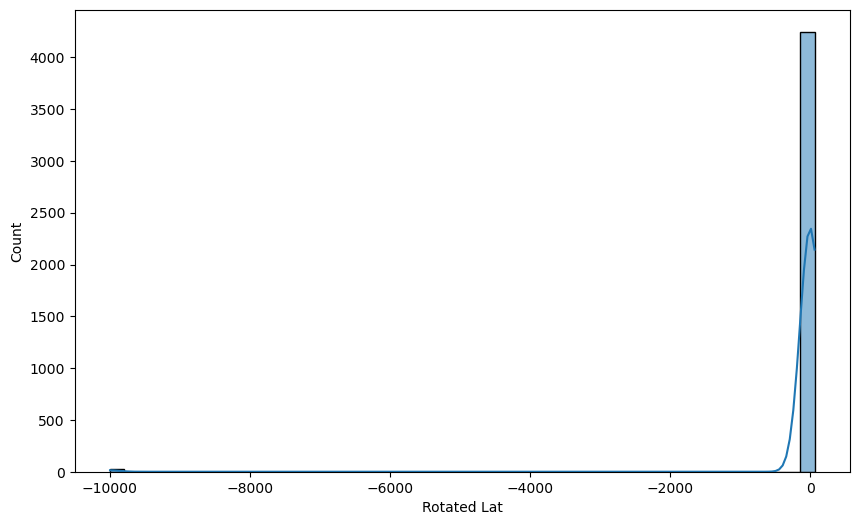

In [128]:
# That seems like a very large std relative to the mean, so let's graph the distribution of 'paleolat'
# Histogram, y axis = count, x axis = paleolat
import matplotlib.pyplot as plt
import seaborn as sns
fix, ax = plt.subplots(figsize=(10, 6))
sns.histplot(rep_bdnn['Rotated Lat'], bins=50, kde=True)
plt.show()

In [129]:
rep_bdnn['Rotated Lat'].describe()

count    4271.000000
mean      -57.827675
std       748.203679
min     -9999.000000
25%       -46.558100
50%         3.836600
75%        26.406800
max        61.323500
Name: Rotated Lat, dtype: float64

In [130]:
rep_bdnn[rep_bdnn['Rotated Lat'] < -70]

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
155,4256,-9999.0000,-9999.0000,Neusticosaurus,marine,247.200,237.0
156,4255,-9999.0000,-9999.0000,Cymatosaurus,marine,247.200,237.0
157,4254,-9999.0000,-9999.0000,Termatosaurus,terrestrial,208.500,201.4
158,4253,-9999.0000,-9999.0000,Ichthyosaurus,marine,208.500,201.4
159,4252,-9999.0000,-9999.0000,Termatosaurus,terrestrial,208.500,201.4
160,4251,-9999.0000,-9999.0000,Ichthyosaurus,marine,208.500,201.4
1382,3029,-9999.0000,-9999.0000,Kenyasaurus,terrestrial,251.902,247.2
2169,2242,-70.3503,-22.9388,Mesosaurus,marine,290.100,283.5
2665,1746,-70.8462,123.5821,Tasmaniosaurus,terrestrial,251.902,251.2
2959,1452,-9999.0000,-9999.0000,Shastasaurus,marine,227.000,208.5


In [131]:
syn_bdnn['Rotated Lat'].describe()

count    3355.000000
mean      -40.600454
std       246.166351
min     -9999.000000
25%       -60.880700
50%       -49.477100
75%        -1.185500
max        62.825200
Name: Rotated Lat, dtype: float64

In [132]:
tem_bdnn['Rotated Lat'].describe()

count    2229.000000
mean      -18.511736
std       561.065379
min     -9999.000000
25%         1.353100
50%        14.567700
75%        39.721600
max        74.642100
Name: Rotated Lat, dtype: float64

Clearly all three datasets have "-9999" in several rows of the 'Rotated Lat' and "Rotated Lng" columns. Reached out to Alex about this, because there is data available in the 'lng' and 'lat' columns, but he says to just drop them

In [148]:
# Need to get the id's of the rows that we're dropping so I can go back and drop these same rows from DeepDive
# These are called the same thing in the DeepDive section
rep_bdnn_dropped_ids = rep_bdnn[rep_bdnn['Rotated Lat'] == -9999.0000]['id']
syn_bdnn_dropped_ids = syn_bdnn[syn_bdnn['Rotated Lat'] == -9999.0000]['id']
tem_bdnn_dropped_ids = tem_bdnn[tem_bdnn['Rotated Lat'] == -9999.0000]['id']
rep_bdnn_dropped_ids

155     4256
156     4255
157     4254
158     4253
159     4252
160     4251
1382    3029
2959    1452
2997    1414
3051    1360
3052    1359
3053    1358
3054    1357
3649     762
3650     761
3651     760
3652     759
3653     758
3654     757
3900     511
3901     510
3904     507
4030     381
4182     229
Name: id, dtype: int64

In [149]:
# I have to go back and drop these rows from the DeepDive datasets
# But since this section is after the DeepDive section, That means I'll run into an error the next time I try to run this nb in order
# , so I'll save these id's off as csv's so that I can load them in and run the DeepDive stuff first the next time I run this nb
rep_bdnn_dropped_ids.to_csv('reptilia_processed_data/reptilia_bdnn_dropped_ids.csv')
syn_bdnn_dropped_ids.to_csv('synapsida_processed_data/synapsida_bdnn_dropped_ids.csv')
tem_bdnn_dropped_ids.to_csv('temnospondyli_processed_data/temnospondyli_bdnn_dropped_ids.csv')

In [133]:
rep_bdnn_dropped = rep_bdnn[rep_bdnn['Rotated Lat'] != -9999.0000]
rep_bdnn_dropped['Rotated Lat'].describe()

count    4247.000000
mean       -1.649635
std        34.773192
min       -70.846200
25%       -46.116400
50%         3.836600
75%        26.462600
max        61.323500
Name: Rotated Lat, dtype: float64

In [144]:
rep_bdnn_dropped['Rotated Lon'].describe()

count    4247.000000
mean        1.843582
std        44.310370
min       -85.215200
25%       -36.588700
50%        -4.655400
75%        20.989100
max       152.608500
Name: Rotated Lon, dtype: float64

In [135]:
# Checking to that the correct number of rows were dropped
rep_bdnn.shape, rep_bdnn_dropped.shape, rep_bdnn[rep_bdnn['Rotated Lat'] == -9999.0000].shape

((4271, 7), (4247, 7), (24, 7))

In [136]:
syn_bdnn_dropped = syn_bdnn[syn_bdnn['Rotated Lat'] != -9999.0000]
syn_bdnn_dropped['Rotated Lat'].describe()

count    3353.000000
mean      -34.660461
std        37.792281
min       -67.429000
25%       -60.880700
50%       -49.477100
75%        -1.185500
max        62.825200
Name: Rotated Lat, dtype: float64

In [145]:
syn_bdnn_dropped['Rotated Lon'].describe()

count    3353.000000
mean       -5.783020
std        29.052976
min       -50.240600
25%       -19.334200
50%       -14.725000
75%         9.627300
max       121.703400
Name: Rotated Lon, dtype: float64

In [137]:
syn_bdnn.shape, syn_bdnn_dropped.shape, syn_bdnn[syn_bdnn['Rotated Lat'] == -9999.0000].shape

((3355, 7), (3353, 7), (2, 7))

In [138]:
tem_bdnn_dropped = tem_bdnn[tem_bdnn['Rotated Lat'] != -9999.0000]
tem_bdnn_dropped['Rotated Lat'].describe()

count    2222.000000
mean       12.929946
std        29.203648
min       -70.949200
25%         1.353100
50%        14.567700
75%        39.997375
max        74.642100
Name: Rotated Lat, dtype: float64

In [139]:
tem_bdnn.shape, tem_bdnn_dropped.shape, tem_bdnn[tem_bdnn['Rotated Lat'] == -9999.0000].shape

((2229, 7), (2222, 7), (7, 7))

#### Visualizing Lat/Lng

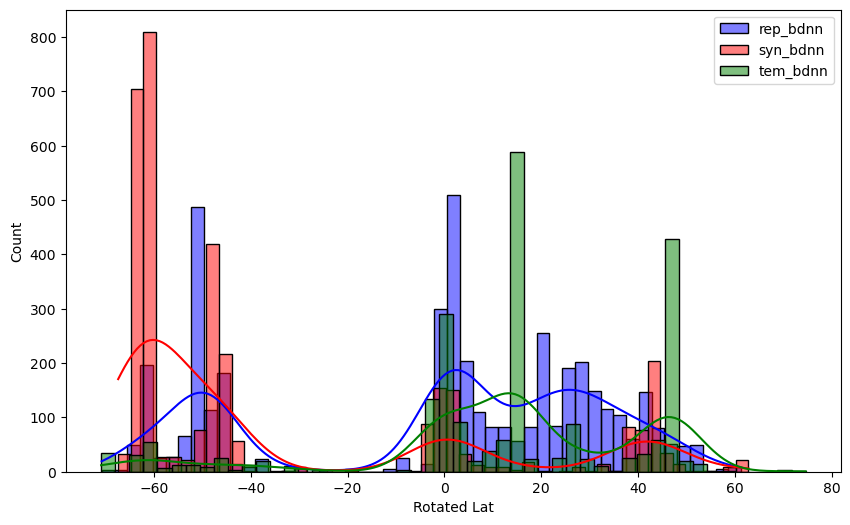

In [140]:
# Create the figure and axes
fix, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms with KDE for each dataset
sns.histplot(rep_bdnn_dropped['Rotated Lat'], bins=50, kde=True, color='blue', label='rep_bdnn', ax=ax)
sns.histplot(syn_bdnn_dropped['Rotated Lat'], bins=50, kde=True, color='red', label='syn_bdnn', ax=ax)
sns.histplot(tem_bdnn_dropped['Rotated Lat'], bins=50, kde=True, color='green', label='tem_bdnn', ax=ax)

# Add the legend
plt.legend()

# Show the plot
plt.show()


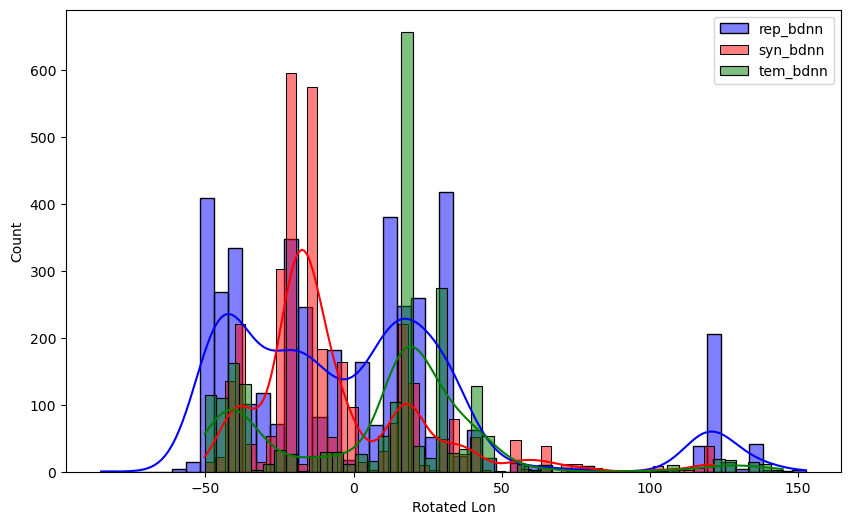

In [143]:
fix, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms with KDE for each dataset
sns.histplot(rep_bdnn_dropped['Rotated Lon'], bins=50, kde=True, color='blue', label='rep_bdnn', ax=ax)
sns.histplot(syn_bdnn_dropped['Rotated Lon'], bins=50, kde=True, color='red', label='syn_bdnn', ax=ax)
sns.histplot(tem_bdnn_dropped['Rotated Lon'], bins=50, kde=True, color='green', label='tem_bdnn', ax=ax)

# Add the legend
plt.legend()

# Show the plot
plt.show()


In [140]:
rep_bdnn_dropped.head()

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2


In [141]:
rep_final.columns

Index(['occurrence_no_x', 'locality', 'county_original', 'state', 'cc',
       'notes', 'id', 'genus', 'age_max', 'age_min'],
      dtype='object')

In [192]:
rep_final[rep_final['genus'] == "Clevosaurs"]

,occurrence_no_x,locality,county_original,state,cc,notes,id,genus,age_max,age_min


In [155]:
tableau_rep = pd.merge(rep_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], rep_final[['id', 'locality']], on='id', how='left')
tableau_rep.shape, rep_bdnn_dropped.shape, rep_final.shape

((4247, 5), (4247, 7), (4271, 10))

In [146]:
tableau_rep.to_csv('reptilia_processed_data/reptilia_tableau.csv', index=False)

In [147]:
tableau_syn = pd.merge(syn_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], syn_final[['id', 'locality']], on='id', how='left')
tableau_syn.shape, syn_bdnn_dropped.shape, syn_final.shape

((3355, 5), (3355, 7), (3355, 10))

In [148]:
tableau_syn.to_csv('synapsida_processed_data/synapsida_tableau.csv', index=False)


In [151]:
tableau_tem = pd.merge(tem_bdnn_dropped[['id', 'Rotated Lat', 'Rotated Lon', 'genus']], tem_cleaned_filtered[['id', 'locality']], on='id', how='left')
tableau_tem.shape, tem_bdnn_dropped.shape, tem_cleaned_filtered.shape

((2229, 5), (2229, 7), (2229, 10))

In [152]:
tableau_tem.to_csv('temnospondyli_processed_data/temnospondyli_tableau.csv', index=False)

#### Saving Backscale.txt's

In [161]:
rep_backscale = pd.DataFrame({"Rotated Lat": [rep_bdnn_dropped['Rotated Lat'].mean(), rep_bdnn_dropped['Rotated Lat'].std()], "Rotated Lon": [rep_bdnn_dropped['Rotated Lon'].mean(), rep_bdnn_dropped['Rotated Lon'].std()]})
syn_backscale = pd.DataFrame({"Rotated Lat": (syn_bdnn_dropped['Rotated Lat'].mean(), syn_bdnn_dropped['Rotated Lat'].std()), "Rotated Lon": (syn_bdnn_dropped['Rotated Lon'].mean(), syn_bdnn_dropped['Rotated Lon'].std())})
tem_backscale = pd.DataFrame({"Rotated Lat": (tem_bdnn_dropped['Rotated Lat'].mean(), tem_bdnn_dropped['Rotated Lat'].std()), "Rotated Lon": (tem_bdnn_dropped['Rotated Lon'].mean(), tem_bdnn_dropped['Rotated Lon'].std())})
rep_backscale, syn_backscale, tem_backscale


(   Rotated Lat  Rotated Lon
 0    -1.649635     1.843582
 1    34.773192    44.310370,
    Rotated Lat  Rotated Lon
 0   -34.660461    -5.783020
 1    37.792281    29.052976,
    Rotated Lat  Rotated Lon
 0    12.929946     9.319296
 1    29.203648    36.968738)

In [162]:
# Checking that the mean and std values are correct in the backscale dfs above
rep_bdnn_dropped.describe()

,id,Rotated Lat,Rotated Lon,age_max,age_min
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,2228.908641,-1.649635,1.843582,241.247062,231.992255
std,1276.333894,34.773192,44.310370,23.353718,25.480204
min,1.000000,-70.846200,-85.215200,201.400000,199.500000
25%,1106.500000,-46.116400,-36.588700,227.000000,208.500000
50%,2263.000000,3.836600,-4.655400,239.700000,237.000000
75%,3332.500000,26.462600,20.989100,254.140000,251.902000
max,4411.000000,61.323500,152.608500,298.900000,293.520000


In [163]:
rep_backscale.to_csv('reptilia_processed_data/reptilia_backscale.txt', sep='\t', index=False)
syn_backscale.to_csv('synapsida_processed_data/synapsida_backscale.txt', sep='\t', index=False)
tem_backscale.to_csv('temnospondyli_processed_data/temnospondyli_backscale.txt', sep='\t', index=False)

#### StandardScaler

In [165]:
from sklearn.preprocessing import StandardScaler

scaler_rep_lat = StandardScaler()
rep_bdnn_dropped['rotated_lat_scaled'] = scaler_rep_lat.fit_transform(rep_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_rep_lng = StandardScaler()
rep_bdnn_dropped['rotated_lon_scaled'] = scaler_rep_lng.fit_transform(rep_bdnn_dropped[['Rotated Lon']]).round(2)

scaler_syn_lat = StandardScaler()
syn_bdnn_dropped['rotated_lat_scaled'] = scaler_syn_lat.fit_transform(syn_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_syn_lng = StandardScaler()
syn_bdnn_dropped['rotated_lon_scaled'] = scaler_syn_lng.fit_transform(syn_bdnn_dropped[['Rotated Lon']]).round(2)

scaler_tem_lat = StandardScaler()
tem_bdnn_dropped['rotated_lon_scaled'] = scaler_tem_lat.fit_transform(tem_bdnn_dropped[['Rotated Lat']]).round(2)

scaler_tem_lng = StandardScaler()
tem_bdnn_dropped['rotated_lon_scaled'] = scaler_tem_lng.fit_transform(tem_bdnn_dropped[['Rotated Lon']]).round(2)


C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_16464\1103344373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_bdnn_dropped['rotated_lat_scaled'] = scaler_rep_lat.fit_transform(rep_bdnn_dropped[['Rotated Lat']]).round(2)
C:\Users\SimoesLabAdmin\AppData\Local\Temp\ipykernel_16464\1103344373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_bdnn_dropped['rotated_lon_scaled'] = scaler_rep_lng.fit_transform(rep_bdnn_dropped[['Rotated Lon']]).round(2)
C:\Users\SimoesLabAdmin\AppData\Local\Te

In [166]:
rep_bdnn_dropped

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
0,4411,6.7390,-20.6269,Icarosaurus,terrestrial,227.000,208.5,0.24,-0.51
1,4410,6.7390,-20.6269,Rutiodon,terrestrial,227.000,208.5,0.24,-0.51
2,4409,35.9688,2.1884,Kuehneosuchus,terrestrial,208.500,201.4,1.08,0.01
3,4408,35.9688,2.1884,Kuehneosaurus,terrestrial,208.500,201.4,1.08,0.01
4,4407,-62.6208,-11.8191,Procolophon,terrestrial,251.902,247.2,-1.75,-0.31
...,...,...,...,...,...,...,...,...,...
4406,5,-47.4217,-18.3424,Eohyosaurus,terrestrial,247.200,242.0,-1.32,-0.46
4407,4,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46
4408,3,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46
4409,2,-47.4217,-18.3424,Mesosuchus,terrestrial,247.200,242.0,-1.32,-0.46


In [167]:
rep_bdnn_dropped.describe()

,id,Rotated Lat,Rotated Lon,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,2228.908641,-1.649635,1.843582,241.247062,231.992255,0.000716,0.000031
std,1276.333894,34.773192,44.310370,23.353718,25.480204,0.999710,1.000576
min,1.000000,-70.846200,-85.215200,201.400000,199.500000,-1.990000,-1.960000
25%,1106.500000,-46.116400,-36.588700,227.000000,208.500000,-1.280000,-0.870000
50%,2263.000000,3.836600,-4.655400,239.700000,237.000000,0.160000,-0.150000
75%,3332.500000,26.462600,20.989100,254.140000,251.902000,0.810000,0.430000
max,4411.000000,61.323500,152.608500,298.900000,293.520000,1.810000,3.400000


## Saving PyRate Input File

In [169]:
# PyRate Input Files
rep_bdnn_dropped_pyrate = rep_bdnn_dropped[['age_max', 'age_min', 'genus']]
syn_bdnn_dropped_pyrate = syn_bdnn_dropped[['age_max', 'age_min', 'genus']]
tem_bdnn_dropped_pyrate = tem_bdnn_dropped[['age_max', 'age_min', 'genus']]

rep_bdnn_dropped_pyrate.to_csv('reptilia_processed_data/reptilia_pyrate.csv', index=False)
syn_bdnn_dropped_pyrate.to_csv('synapsida_processed_data/synapsida_pyrate.csv', index=False)
tem_bdnn_dropped_pyrate.to_csv('temnospondyli_processed_data/temnospondyli_pyrate.csv', index=False)

## Species Trait File

#### EDA Coords Standard Deviation

In [236]:
# PyRate only takes SPECIES specific traits, not OCCURRENCE specific traits, so lat and lng need to be averaged by "genus" column
# Grouping by genus and getting std values to see if lat and lng values for each genus have a lot of variance
# If there is a lot of variance, it might not be justifiable to average the lat and lng values
rep_bdnn_stds = rep_bdnn_dropped[['rotated_lat_scaled', 'rotated_lon_scaled', 'genus']].groupby('genus').std()
rep_bdnn_stds

,rotated_lat_scaled,rotated_lon_scaled
genus,,
Abyssomedon,NaN,NaN
Acadiella,NaN,NaN
Acaenasuchus,0.000000,0.000000
Acallosuchus,NaN,NaN
Acerosodontosaurus,NaN,NaN
...,...,...
Yunguisaurus,0.000000,0.000000
Yunnanosaurus,0.000000,0.000000
Zanclodon,0.112339,0.142829


In [237]:
# Saving off only those with std > 0
lat_stds = rep_bdnn_stds[rep_bdnn_stds['rotated_lat_scaled'] > 0]
lon_stds = rep_bdnn_stds[rep_bdnn_stds['rotated_lon_scaled'] > 0]

In [238]:
lat_stds.equals(lon_stds)

False

In [239]:
# Looking at std's that are > 0, largest to smallest
lat_stds.sort_values('rotated_lat_scaled', ascending=False)


,rotated_lat_scaled,rotated_lon_scaled
genus,,
Garjainia,1.576710,0.564351
Procolophonichnium,1.420282,0.496521
Tetrasauropus,1.368320,0.658179
Teratosaurus,1.235570,0.653911
Proterosuchus,1.108144,0.705648
...,...,...
Uatchitodon,0.005774,0.320468
Krzyzanowskisaurus,0.005774,0.046188
Hemilopas,0.005774,0.011547


In [231]:
lat_stds[lat_stds.index == 'Clevosaurus']

,rotated_lat_scaled,rotated_lon_scaled
genus,,
Clevosaurus,1.079502,0.462314


In [217]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Garjainia']

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
1968,2443,46.9132,47.1091,Garjainia,terrestrial,251.2,247.2,1.40,1.02
2313,2098,48.3133,44.0363,Garjainia,terrestrial,251.2,247.2,1.44,0.95
2742,1669,-58.7619,-5.3084,Garjainia,terrestrial,248.9,247.2,-1.64,-0.16
3588,823,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3589,822,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3590,821,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3591,820,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3592,819,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3593,818,-58.7619,-5.3084,Garjainia,terrestrial,251.2,247.2,-1.64,-0.16
3594,817,-60.6853,0.0780,Garjainia,terrestrial,251.2,247.2,-1.70,-0.04


In [257]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Clevosaurus'].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
3995,416,-49.4771,-10.0175,Clevosaurus,terrestrial,237.0,227.0,-1.38,-0.27
4344,67,-47.3188,-9.0563,Clevosaurus,terrestrial,227.0,208.5,-1.31,-0.25
1464,2948,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1461,2945,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1460,2944,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1459,2943,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1458,2942,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1457,2941,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1456,2940,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
4351,60,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15


In [218]:
lon_stds.sort_values('rotated_lon_scaled', ascending=False)

,rotated_lat_scaled,rotated_lon_scaled
genus,,
Utatsusaurus,0.186145,2.484566
Mixosaurus,0.106515,1.473495
Tholodus,0.341211,1.395167
Phalarodon,0.272832,1.309891
Askeptosaurus,0.050332,1.290852
...,...,...
Eucoelophysis,0.098995,0.007071
Paralonectes,0.023094,0.005774
Barracudasaurus,0.040415,0.005774


In [199]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Utatsusaurus']

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
1381,3030,32.0407,152.6085,Utatsusaurus,marine,251.200,247.2,0.97,3.40
1590,2821,32.0407,152.6085,Utatsusaurus,marine,248.900,247.2,0.97,3.40
3736,675,17.2920,-46.5877,Utatsusaurus,marine,248.900,247.2,0.54,-1.09
3921,490,31.6180,-40.9603,Utatsusaurus,marine,251.902,248.9,0.96,-0.97
3922,489,30.0552,-57.1861,Utatsusaurus,marine,251.200,248.9,0.91,-1.33


Lat and lon values for ~235 species (in reptilia) have standard deviations > 0. To handle this, we're going to 
1. ID any species that have lat and lon values that span > 20 degrees (range > 20)
2. Split those species into several categories

#### EDA Coords By Range

In [261]:
rep_bdnn_range = rep_bdnn_dropped[['Rotated Lat', 'Rotated Lon', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                                lon_range=('Rotated Lon', lambda x: x.max() - x.min()),
                                                                                                lon_min = ('Rotated Lon', lambda x: x.min()),
                                                                                                lon_max = ('Rotated Lon', lambda x: x.max()))
rep_bdnn_range

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Abyssomedon,0.0000,-0.7300,-0.7300,0.0000,-37.6741,-37.6741
Acadiella,0.0000,10.5874,10.5874,0.0000,-11.8909,-11.8909
Acaenasuchus,0.0000,1.3531,1.3531,0.0000,-47.1801,-47.1801
Acallosuchus,0.0000,1.3531,1.3531,0.0000,-47.1801,-47.1801
Acerosodontosaurus,0.0000,-50.0920,-50.0920,0.0000,31.3299,31.3299
...,...,...,...,...,...,...
Yunguisaurus,0.0000,18.7825,18.7825,0.0000,119.7653,119.7653
Yunnanosaurus,0.0000,52.1412,52.1412,0.0000,136.1873,136.1873
Zanclodon,9.8519,26.1169,35.9688,15.2919,2.1884,17.4803


In [262]:
rep_bdnn_range[(rep_bdnn_range['lat_range'] > 0) | (rep_bdnn_range['lon_range'] > 0)]

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Aetosauroides,19.2086,-56.0316,-36.8230,57.2441,-29.5316,27.7125
Aetosaurus,12.2457,20.3475,32.5932,2.3135,9.3339,11.6474
Amanasaurus,9.9152,-56.0316,-46.1164,24.4663,-10.0175,14.4488
Ammorhynchus,0.9441,8.5619,9.5060,2.9597,-46.6177,-43.6580
Amotosaurus,4.0874,22.9805,27.0679,3.2667,17.1911,20.4578
...,...,...,...,...,...,...
Vjushkovisaurus,1.9393,46.8850,48.8243,1.7945,40.4161,42.2106
Weigeltisaurus,2.0215,25.6133,27.6348,9.4133,12.9250,22.3383
Xinpusaurus,8.2288,18.7825,27.0113,1.2195,118.5458,119.7653


In [263]:
rep_bdnn_range[(rep_bdnn_range['lat_range'] > 20) | (rep_bdnn_range['lon_range'] > 20)]

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Aetosauroides,19.2086,-56.0316,-36.8230,57.2441,-29.5316,27.7125
Amanasaurus,9.9152,-56.0316,-46.1164,24.4663,-10.0175,14.4488
Anchisauripus,44.3906,3.8468,48.2374,73.4754,-47.0031,26.4723
Angistorhinus,8.3572,1.3572,9.7144,45.3523,-50.2406,-4.8883
Anomoepus,48.3036,3.8376,52.1412,159.6741,-23.4868,136.1873
...,...,...,...,...,...,...
Tetrasauropus,82.4384,-49.5084,32.9300,50.6508,-37.0935,13.5573
Tholodus,28.9933,12.9243,41.9176,124.2835,20.6392,144.9227
Uatchitodon,0.6295,1.3531,1.9826,24.8007,-47.1801,-22.3794


In [256]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Anomoepus'].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
4090,321,3.8376,-23.1639,Anomoepus,terrestrial,227.0,213.2,0.16,-0.56
3640,771,6.3169,-23.4868,Anomoepus,terrestrial,227.0,208.5,0.23,-0.57
4112,299,16.9917,-16.5851,Anomoepus,terrestrial,201.4,199.5,0.54,-0.42
522,3889,16.9917,-16.5851,Anomoepus,terrestrial,201.4,199.5,0.54,-0.42
1729,2682,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1728,2683,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1722,2689,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1720,2691,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1715,2696,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36
1704,2707,20.0114,-14.2092,Anomoepus,terrestrial,201.4,199.5,0.62,-0.36


In [264]:
rep_lat_range_20 = rep_bdnn_range[rep_bdnn_range['lat_range'] > 20]
rep_lat_range_20

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Anchisauripus,44.3906,3.8468,48.2374,73.4754,-47.0031,26.4723
Anomoepus,48.3036,3.8376,52.1412,159.6741,-23.4868,136.1873
Apatopus,33.8313,-0.5164,33.3149,67.7947,-50.1976,17.5971
Atreipus,26.5759,6.7390,33.3149,38.2240,-20.6269,17.5971
Batrachopus,27.8992,6.0887,33.9879,67.4301,-50.2390,17.1911
...,...,...,...,...,...,...
Stereosternum,24.6904,-68.9066,-44.2162,8.9818,-36.4694,-27.4876
Tanystropheus,52.3570,-9.6503,42.7067,127.5648,-7.7995,119.7653
Teratosaurus,77.2946,-44.7014,32.5932,54.9313,9.3339,64.2652


In [270]:
(rep_lat_range_20[rep_lat_range_20.index == 'Anomoepus']['lat_min'] + rep_lat_range_20[rep_lat_range_20.index == 'Anomoepus']['lat_max']) / 2

genus
Anomoepus    27.9894
dtype: float64

In [265]:
rep_lon_range_20 = rep_bdnn_range[rep_bdnn_range['lon_range'] > 20]
rep_lon_range_20

,lat_range,lat_min,lat_max,lon_range,lon_min,lon_max
genus,,,,,,
Aetosauroides,19.2086,-56.0316,-36.8230,57.2441,-29.5316,27.7125
Amanasaurus,9.9152,-56.0316,-46.1164,24.4663,-10.0175,14.4488
Anchisauripus,44.3906,3.8468,48.2374,73.4754,-47.0031,26.4723
Angistorhinus,8.3572,1.3572,9.7144,45.3523,-50.2406,-4.8883
Anomoepus,48.3036,3.8376,52.1412,159.6741,-23.4868,136.1873
...,...,...,...,...,...,...
Tetrasauropus,82.4384,-49.5084,32.9300,50.6508,-37.0935,13.5573
Tholodus,28.9933,12.9243,41.9176,124.2835,20.6392,144.9227
Uatchitodon,0.6295,1.3531,1.9826,24.8007,-47.1801,-22.3794


In [271]:
rep_bdnn_dropped[rep_bdnn_dropped['genus'] == 'Clevosaurus'].sort_values('Rotated Lat')

,id,Rotated Lat,Rotated Lon,genus,taxon_environment,age_max,age_min,rotated_lat_scaled,rotated_lon_scaled
3995,416,-49.4771,-10.0175,Clevosaurus,terrestrial,237.0,227.0,-1.38,-0.27
4344,67,-47.3188,-9.0563,Clevosaurus,terrestrial,227.0,208.5,-1.31,-0.25
1464,2948,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1461,2945,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1460,2944,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1459,2943,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1458,2942,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1457,2941,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
1456,2940,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15
4351,60,-46.1164,-4.6554,Clevosaurus,terrestrial,227.0,208.5,-1.28,-0.15


### Dropping Lon, Binning Lat

Decided to drop longitude as a predictor entirely, because of an issue illustrated in the above:
- Clevosaurus latitudes -30+ have longitudes that range from (27 to -4). That means even if we split Clevosaurus by latitude, the -30 to -50 range of Clevosaurus (let's call that "Clevosaurus_South", essentially a new genus) would still have a wide range of longitudes. 
- We still need per-genus trait data for BDNN, so we'd have to average out that wide range of longitudinal values (27 to -4), which misrepresents the actual distribution -- that was our original issue with Clevosaurus as a whole, the reason that we decided to bucket together occurrences in the latitude range of -30 to -50
- In order to avoid that, we'd have to do another further split of the Clevosaurus_South genus, into Clevosaurus_South_East (latitude -30 to -50 and longitude 20+), and Clevosaurus_South_West (latitude -30 to -50 and longitude -4 on). 
- Leads to too many categories

Solution: 
1. Drop longitude as a predictor
2. Find all genera with latitude ranges > 20 degrees
3. Define new latitudinal categories based on Earth's environment
4. For those genera, create new artificial genera categorized by those latitudinal categories 

In [273]:
rep_bdnn_dropped.columns

Index(['id', 'Rotated Lat', 'Rotated Lon', 'genus', 'taxon_environment',
       'age_max', 'age_min', 'rotated_lat_scaled', 'rotated_lon_scaled'],
      dtype='object')

In [ ]:
rep_bdnn_range = rep_bdnn_dropped[['Rotated Lat', 'Rotated Lon', 'genus']].groupby('genus').agg(lat_range=('Rotated Lat', lambda x: x.max() - x.min()), 
                                                                                                lat_min = ('Rotated Lat', lambda x: x.min()), 
                                                                                                lat_max = ('Rotated Lat', lambda x: x.max()),
                                                                                                lon_range=('Rotated Lon', lambda x: x.max() - x.min()),
                                                                                                lon_min = ('Rotated Lon', lambda x: x.min()),
                                                                                                lon_max = ('Rotated Lon', lambda x: x.max()))
rep_bdnn_range

In [ ]:
# Range of >= 20 in lat, split into N and S

rep_lat_range = rep_bdnn_dropped[]


In [ ]:
# rep_bdnn_final.to_csv('reptilia_processed_data/reptilia_bdnn.csv')
# syn_filtered.to_csv('synapsida_processed_data/synapsida_bdnn.csv')
# tem_filtered.to_csv('temnospondyli_processed_data/temnospondyli_bdnn.csv')